In [1]:
%matplotlib inline

from bs4 import BeautifulSoup
import urllib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tqdm import tqdm,tqdm_notebook
import os
import random
import time

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input, concatenate, Reshape, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,UpSampling2D,Lambda, Activation, ZeroPadding2D, Deconv2D
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.regularizers import l1_l2

from keras.utils import to_categorical 

import matplotlib

import gc
import collections

class MyException(Exception):
    pass

Using TensorFlow backend.


In [2]:
HOWMANY = 1107
MAXLINKS = 1109
DEBUG = True
TMP_DIR = 'C:\\Users\\grzegorz\\Downloads\\RoadFinder-master (1)\\img'
FORCE_RELOAD = False#True
LOAD = True
PREPROCESS = True#False
batch_size = 128   # ile obrazków przetwarzamy na raz (aktualizacja wag sieci następuje raz na całą grupę obrazków)
epochs = 50         # ile epok będziemy uczyli
SIZE = (750,750)
SIDE = 250
IMPOSITION = 15
HOWMANYPERIMAGE = int(SIZE[0]*SIZE[1]/SIDE/SIDE)
IMAGESPERFILE = 25
assert int(SIZE[0]*SIZE[1]/SIDE/SIDE)==HOWMANYPERIMAGE
channels = 5

In [3]:
def loadImage(url):
    raw = urllib.request.urlopen(url).read()
    npraw= np.array(bytearray(raw),dtype=np.uint8)
    return cv2.imdecode(npraw,-1)#-1 -> as is (with the alpha channel)

def getImageName(url):
    return url.split('/').pop().split('.').pop(0)

def pickleBigDataset(prefix,dataset,size):
    j = int(np.ceil(len(dataset)/size))
    for i in range(1,j+1):
        np.save(os.path.join(TMP_DIR, prefix+str(i)),np.array(dataset[size*(i-1):size*i]))

def unpickleBigDataset(prefix):
    onlyfiles = [f for f in os.listdir(TMP_DIR) if os.path.isfile(os.path.join(TMP_DIR, f))
                 and f.startswith(prefix)]
    dataset = []
    if len(onlyfiles)>0:
        print("Loading...")
        dataset = np.load(os.path.join(TMP_DIR, onlyfiles[0]))
        print("Loaded first")
        for f in tqdm_notebook(onlyfiles[1:]):
            dataset=np.append(dataset,np.load(os.path.join(TMP_DIR, f)),axis=0)
    return dataset

def unpickleBigDataset2(ending,start,stop):
    onlyfiles = [f for f in os.listdir(TMP_DIR) if os.path.isfile(os.path.join(TMP_DIR, f))
                 and f.endswith(ending)]
    dataset = []
    if len(onlyfiles)>0:
        print("Loading...")
        dataset = np.load(os.path.join(TMP_DIR, str(start)+ending))
        print("Loaded first")
        for f in range(start+1,stop+1):
            dataset=np.append(dataset,[np.load(os.path.join(TMP_DIR, str(f)+ending))])
    return dataset
#     return np.load(os.path.join(TMP_DIR, "{}.npy".format(prefix)))
    
            
def loadImagesFromSite(url,prefix):
    onlyfiles = [f for f in os.listdir(TMP_DIR) if os.path.isfile(os.path.join(TMP_DIR, f)) and f.startswith(prefix)]
    if len(onlyfiles)==0 or FORCE_RELOAD:
        imgs = []
        I = None
        
    else:
        imgs = [img for img in unpickleBigDataset(prefix)[:HOWMANY]]
        I = len(imgs)
    print("Cached images {}.".format(I if I is not None else 0))
    
    if (HOWMANY is not None and len(imgs)<HOWMANY and len(imgs)<MAXLINKS) or (len(imgs)<MAXLINKS and HOWMANY is None):
        print("Loading images from {}".format(url))
        print("Proceeding from {} image.".format(I if I is not None else 0))

        s = IMAGESPERFILE

        with urllib.request.urlopen(url) as response:
            html = BeautifulSoup(response.read(),"lxml")
            i = I if I is not None else 0
            links = html.find_all('a')[I:HOWMANY]
            for link in tqdm_notebook(links):
                img = loadImage(link.get('href'))  
                img = cv2.resize(img,SIZE)
#                 print(link.get('href'))
                imgs += [cv2.resize(img,SIZE)]
                if i%s==0:
                    pickleBigDataset(prefix,imgs,s)
                i+=1
        pickleBigDataset(prefix,imgs,s)
    
        
    return np.array(imgs)  

def saveDataset(X,Y,prefix=""):
    with open('pickledDatasetX'+prefix,'wb') as f:
        pickle.dump(X,f)
    with open('pickledDatasetY'+prefix,'wb') as f:
        pickle.dump(Y,f)
        
def loadDataset(prefix=""):
    try:
        X = unpickleBigDataset('x')
        Y = unpickleBigDataset('y')
        if len(X) == len(Y) and len(X) == HOWMANY:
            return X,Y
        else:
            print("Failed loading dataset from file system")
            return None,None
    except:
        print("Failed loading dataset from file system")
        return None,None
    
def display(X,Y,howmany=None):
    if howmany is None:
        howmany = X.shape[0]
        
    for i in range(howmany):
        print(X[i].max(),X[i].min())
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(X[i])
        plt.subplot(1,2,2)
        plt.imshow(Y[i])
        
def create_weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy
        

In [4]:
# def get_patches(image,size,side,imposition):
#     patches = []
    
    
#     for i in range(int(size[0]/side)):
#         for j in range(int(size[1]/side)):
#             patches += [image[i*side:(i+1)*side,j*side:(j+1)*side]]
#     return patches

def get_patches(image,size,side,imposition):
    patches = []
    
    if len(image.shape)==3:
        img = np.zeros((image.shape[0]+imposition,image.shape[1]+imposition,4))
        for i in range(4):
            img[...,i] = np.pad(image[...,i],((imposition,0),(imposition,0)),'reflect')
        image = img
    else:
        image = np.pad(image,((imposition,0),(imposition,0)),'reflect')

    for i in range(int(size[0]/side)):
        for j in range(int(size[1]/side)):
            imp1=np.max([i*side-imposition,0])
            imp2=(i+1)*side+imposition if imp1!=0 else (i+1)*side+imposition*2
            imp3=np.max([j*side-imposition,0])
            imp4=(j+1)*side+imposition if imp3!=0 else (j+1)*side+imposition*2
            patches += [image[imp1:imp2,imp3:imp4]]
    return patches

def preprocessorX(image):
    size,side,imposition = SIZE,SIDE,IMPOSITION
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    image = image.astype(np.float32)

    if image.max() > 1:
        image /= 255

    img = np.zeros((image.shape[0], image.shape[1], 4))
    img[...,3] = np.max(image,axis=2) - np.min(image,axis=2)
    img[...,3] -= img[...,3].mean()
    img[...,3] /= img[...,3].std()
    for i in range(3):
        image[...,i] -= image[...,i].mean()
        image[...,i] /= image[...,i].std()
        img[...,i] = image[...,i]
    

    #remove outliers
    img[img<-3] = -3
    img[img>3] = 3

    #between -1,1
    for i in range(4):
        img[...,i] /= np.max(np.abs([img[...,i].min(),img[...,i].max()]))

    return get_patches(img,size,side,imposition)
    
def preprocessorY(image):
    size,side,imposition = SIZE,SIDE,IMPOSITION

    image = image.astype(np.float32)
    image[image != 0] = 1
    return get_patches(image,size,side,imposition)
    
def getRoadStats(arr,mask):
    b = mask.astype(np.bool)
    x = arr[b]
    if len(x) != 0:
        return [x.max(0),x.min(0),x.mean(0),x.std(0),np.median(x,axis=0)]
    else:
        return None

def preprocessXY(X,Y):
    
    r = []
    for i in range(len(X)):
        s = getRoadStats(X[i],Y[i])
        if s is not None:
            r += [s]
            
    return np.array(r).mean(0)
    

def preprocess(images,preprocessor,prefix):
    onlyfiles = [f for f in os.listdir(TMP_DIR) if os.path.isfile(os.path.join(TMP_DIR, f)) and f.startswith(prefix)]
    if len(onlyfiles)==0:
        I = None
        result = []
    else:
        result = unpickleBigDataset(prefix)[:HOWMANY*HOWMANYPERIMAGE]
        I = int(len(result)/HOWMANYPERIMAGE)
    print("Cached images {}.".format(len(result)))
    
    s = int(IMAGESPERFILE*HOWMANYPERIMAGE / 4 )
    if len(result)<HOWMANY*HOWMANYPERIMAGE:
        print("Preprocessing images.")
        print("Proceeding from {} image.".format(I if I is not None else 0))
        i = I if I is not None else 0
        ignoring = []
        for image in tqdm_notebook(images[I:]):
            r = preprocessor(image)
            result += r
#             i += HOWMANYPERIMAGE
#             if i%s==0:
#                 pickleBigDataset(prefix,result,s)
        images = None
        gc.collect()
        pickleBigDataset(prefix,result,s)
    images = None
        
    return np.array(result)


def max_pred(y_true, y_pred):

    return K.max(y_pred)

    

def min_pred(y_true, y_pred):

    return K.min(y_pred)

In [5]:
def doSomeDeepLearning(X=None,Y=None,side=250,x_test=None,y_test=None):
    num_classes = 2    # ile klas będziemy rozpoznawali

    # input image dimensions
    img_rows, img_cols = side,side   # takie wymiary mają obrazki w bazie MNIST

    # the data, shuffled and split between train and test sets
    try:
        raise MyException
        x_train = unpickleBigDataset('xain')
        y_train = unpickleBigDataset('yain')
        x_test = unpickleBigDataset('xest')
        y_test = unpickleBigDataset('yest')
        if len(x_train)==0 or len(y_train)==0 or len(x_test)==0 or len(y_test)==0:
            raise Exception
        if len(x_train) + len(x_test)!=HOWMANY:
            raise MyException
    except:
#         x_test = unpickleBigDataset2("m.npy",21500,21824)
#         y_test = unpickleBigDataset2("b.npy",21500,21824)
#         if K.image_data_format() == 'channels_first':
#             x_test = x_test.reshape(325, 4, img_rows, img_cols)
#             y_test = y_test.reshape(325, img_rows * img_cols)
#             input_shape = (4, img_rows, img_cols)
#         else:
#             x_test = x_test.reshape(325, img_rows, img_cols, 4)
#             y_test = y_test.reshape(325, img_rows * img_cols)
#             input_shape = (img_rows, img_cols, 4)
#         s = IMAGESPERFILE * HOWMANYPERIMAGE
#         pickleBigDataset('xain',x_train,s)
#         pickleBigDataset('yain',y_train,s)
#         pickleBigDataset('xest',x_test,s)
#         pickleBigDataset('yest',y_test,s)

#     print('x_train shape:', x_train.shape)
#     print(x_train.shape[0], 'train samples')
#     print(x_test.shape[0], 'test samples')
        None
    curr_epoch = -1
    onlyfiles = [f for f in os.listdir('.') if os.path.isfile(os.path.join('.', f)) and f.startswith('moj_ulubiony_model') and f.endswith('.h5')]
    if len(onlyfiles) == 0:
        print("No saved model. Preparing model.")
        imput = Input(shape=(side,side,channels))
        conv1 = Conv2D(32, 
                       kernel_size=(7,7),
#                        padding="same", 
                       activation='elu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(imput)
        conv12 = Conv2D(32,
                       kernel_size=(5,5),
#                        padding="same", 
                       activation='elu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv1)
        bn11 = BatchNormalization()(conv12)
        conv15 = Conv2D(64, 
                       kernel_size=(3,3),
#                        padding="same", 
                       activation='elu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(bn11)
        conv16 = Conv2D(64, 
                       kernel_size=(3,3),
#                        padding="same", 
                       activation='elu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv15)
        bn12 = BatchNormalization()(conv16)
        deconv16 = Deconv2D(64, 
                       kernel_size=(3,3),
#                        padding="same", 
                       activation='elu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(bn12)
        deconv15 = Deconv2D(64, 
                       kernel_size=(3,3),
#                        padding="same", 
                       activation='elu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(deconv16)
        bn21 = BatchNormalization()(deconv15)
        deconv12 = Deconv2D(32, 
                       kernel_size=(5,5),
#                        padding="same", 
                       activation='elu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(bn21)
        end = Deconv2D(1, 
                       kernel_size=(7,7),
#                        padding="same", 
                       activation='linear',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(deconv12)

        model = Model(inputs=imput, outputs=end)

        model.compile(loss=keras.losses.binary_crossentropy,#
                  optimizer=keras.optimizers.Adam(),       
                  metrics=[max_pred,min_pred,'accuracy'])#'accuracy'])#,'precision','recall'])
    
#     elif len(onlyfiles) == 1:
#         print("Saved model:\"{}\"".format(onlyfiles[0]))
#         model = keras.models.load_model(onlyfiles[0])
    else:
#         onlyfiles = map(lambda y:filter(lambda x:x is not None and x.startswith('epoch'),y.split('.')[0].split('_')),onlyfiles)
#         curr_epoch = max(list(map(lambda x:int(x[4:]),onlyfiles)))
        curr_epoch = 0
        model = keras.models.load_model("moj_ulubiony_model_epoch{}.h5".format(curr_epoch),custom_objects={"max_pred":max_pred,"min_pred":min_pred})
        print("Saved model:\"moj_ulubiony_model_epoch{}.h5\"".format(curr_epoch))
    curr_epoch += 1
    print("Current epoch:{}".format(curr_epoch))
    model.summary()
    
    mbs=80
    for i in range(curr_epoch,epochs):
        trainRange = [i for i in range(800)]
        random.shuffle(trainRange)
        for j in range(800//mbs):
            x_train = np.array([])
            y_train = np.array([])
            for l in range(mbs):
                x_train = np.append(x_train, unpickleBigDataset2('m.npy', trainRange[j*mbs+l], trainRange[j*mbs+l]))
                y_train = np.append(y_train, unpickleBigDataset2('b.npy', trainRange[j*mbs+l], trainRange[j*mbs+l]))
            if input_shape[0]!=4:
                x_train = x_train.reshape(mbs * IMAGESPERFILE, img_rows, img_cols, channels)
                y_train = y_train.reshape(mbs * IMAGESPERFILE, img_rows, img_cols, 1)
            else:
                x_train = x_train.reshape(mbs * IMAGESPERFILE, channels, img_rows, img_cols)
                y_train = y_train.reshape(mbs * IMAGESPERFILE, 1, img_rows, img_cols)
            print(x_train.shape)
            model.fit(x_train, y_train,
                          batch_size=5,
                          epochs=15,
                          verbose=1,
                          validation_data=(x_test, y_test))
            time.sleep(60)
#             asd = model.predict(np.array([x_train[0]]))
#             print(asd.shape)
#             print(asd)
            model.save("moj_ulubiony_model_epoch{}.h5".format(i))
    
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [13]:
if __name__=="__main__":
    ex=1
    try:
#         raise MyException()
        doSomeDeepLearning()
    except MyException as e:
#         while ex==1:
#             try:
                ex=0
                urlX = "https://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/index.html"
                urlY = "https://www.cs.toronto.edu/~vmnih/data/mass_roads/train/map/index.html"

                if LOAD:
                    print("Loading images (X)")
#                     X = unpickleBigDataset('f')
                if PREPROCESS:
                    print("Preprocessing images (X)")
#                     X = preprocess(X,preprocessorX,'x')
                if LOAD:
                    print("Loading images (Y)")
                    Y = unpickleBigDataset('z')
                if PREPROCESS:
                    print("Preprocessing images (Y)")
                    Y = preprocess(Y,preprocessorY,'y')

                    r = preprocessXY(X,Y)
#                     quit()
                    print("\n\t| {}\t\t\t| {}\t\t| {}".format('Hue', 'Saturation', 'Value'))
                    l = ['max','min','avg','std','median']
                    for i,(c1, c2, c3) in enumerate(r):  
                        print("{}\t| {}\t| {}\t| {}".format(l[i],c1, c2, c3))

                doSomeDeepLearning(X,Y)
#             except Exception:
#                 ex=1

No saved model. Preparing model.
Current epoch:0
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 250, 250, 4)  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 250, 250, 32) 6304        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 250, 250, 32) 25632       conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 250, 250, 32) 9248        conv2d_32[0][0]                  
____________________________________________________________

KeyboardInterrupt: 

In [ ]:
x=np.array([[[1,2,3], [1,2,4]],[[4,2,3], [3,2,2]]])
np.max(x,axis=2)-np.min(x,axis=2)

In [6]:
ts=800
te=872
x=te-ts+1
x_test = unpickleBigDataset2("m.npy",ts,te)
y_test = unpickleBigDataset2("b.npy",ts,te)
side=250
img_rows, img_cols = side,side
if K.image_data_format() == 'channels_first':
#             x_train = x_train.reshape(x_train.shape[0], 4, img_rows, img_cols)
    x_test = x_test.reshape(x * IMAGESPERFILE, channels, img_rows, img_cols)
#             y_train = y_train.reshape(y_train.shape[0], 1, img_rows, img_cols)
    y_test = y_test.reshape(x * IMAGESPERFILE, 1, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
#             x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 4)
    x_test = x_test.reshape(x * IMAGESPERFILE, img_rows, img_cols, channels)
#             y_train = y_train.reshape(y_train.shape[0], img_rows, img_cols, 1)
    y_test = y_test.reshape(x * IMAGESPERFILE, img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, channels)

Loading...
Loaded first
Loading...
Loaded first


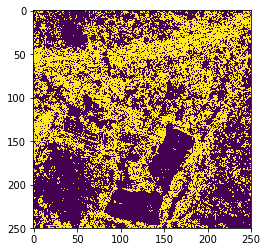

In [16]:
matplotlib.pyplot.imshow(x_test[357,...,4].astype(np.int))

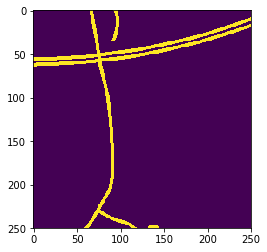

In [14]:
matplotlib.pyplot.imshow(y_test[357,...,0].astype(np.int))

In [64]:
model = keras.models.load_model("moj_ulubiony_model_epoch0.h5", custom_objects={"max_pred":max_pred,"min_pred":min_pred,"weighted_binary_crossentropy":create_weighted_binary_crossentropy(0.01,0.99)})

Loading...
Loaded first


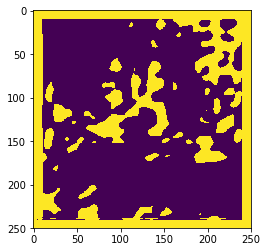

In [73]:
x = unpickleBigDataset2("m.npy",5,5)
x = np.reshape(x,(25,250,250,5))
w = model.predict(np.array([x[0]]))
# x_test.shape
# w=y_test[5:6]
w = np.reshape(w, (250,250))
w -= w.min()
w /= w.max()
w[w<0.009525] = 0
w[w>0] = 1
plt.imshow(w)

In [45]:
def to3ch(im):
    side = 750
    im = im.reshape(side, side, 1)
    img = np.concatenate((im,im,im),axis=2)
    print(img.shape)
#     print(img)
    return img

x_test +=1
x_test /=2
for i in range(100,110):
    img = to3ch(y_test[i])
    matplotlib.image.imsave("a"+str(i),img)
    matplotlib.image.imsave("b"+str(i),x_test[i][...,0:3])

ValueError: cannot reshape array of size 62500 into shape (750,750,1)

In [13]:
x = unpickleBigDataset2('f',5,8)
y = unpickleBigDataset2('z',5,8)
x= x.reshape(x.shape[0], 750,750,3)
y=y.reshape(y.shape[0], 750,750)
img = to3ch(y[0])
matplotlib.image.imsave("a"+str(12),img)
matplotlib.image.imsave("b"+str(12),x[0])

Loading...
Loaded first
Loading...
Loaded first
(750, 750, 3)


In [11]:
x_train = np.array([])
y_train = np.array([])

In [ ]:
doSomeDeepLearning(x_test=x_test,y_test=y_test)

No saved model. Preparing model.
Current epoch:0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 250, 5)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 244, 244, 32)      7872      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 240, 240, 32)      25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 240, 240, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 238, 238, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 236, 236, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batc

 475/2000 [======>.......................] - ETA: 41:00 - loss: 2501391.2500 - max_pred: 67.0291 - min_pred: -45.4585 - acc: 0.043 - ETA: 21:54 - loss: 2750444.2500 - max_pred: 73.4277 - min_pred: -53.2142 - acc: 0.036 - ETA: 15:31 - loss: 2659899.0833 - max_pred: 72.7569 - min_pred: -50.2259 - acc: 0.037 - ETA: 12:20 - loss: 2555897.8750 - max_pred: 66.9456 - min_pred: -47.6822 - acc: 0.041 - ETA: 10:26 - loss: 2490713.7500 - max_pred: 61.7858 - min_pred: -48.1455 - acc: 0.042 - ETA: 9:09 - loss: 2426174.8750 - max_pred: 57.9105 - min_pred: -48.4705 - acc: 0.043 - ETA: 8:14 - loss: 2371731.3393 - max_pred: 55.5009 - min_pred: -47.1259 - acc: 0.04 - ETA: 7:33 - loss: 2322663.5312 - max_pred: 53.8398 - min_pred: -46.0526 - acc: 0.04 - ETA: 7:00 - loss: 2278438.2361 - max_pred: 52.7409 - min_pred: -44.9029 - acc: 0.04 - ETA: 6:34 - loss: 2238897.9500 - max_pred: 51.1179 - min_pred: -43.9282 - acc: 0.04 - ETA: 6:13 - loss: 2201921.0909 - max_pred: 49.8708 - min_pred: -43.5514 - acc: 0.04 

 950/2000 [=============>................] - ETA: 2:32 - loss: 1163588.8288 - max_pred: 26.6827 - min_pred: -26.0677 - acc: 0.11 - ETA: 2:31 - loss: 1158745.1682 - max_pred: 26.5434 - min_pred: -25.9650 - acc: 0.11 - ETA: 2:30 - loss: 1154246.1926 - max_pred: 26.4379 - min_pred: -25.8442 - acc: 0.11 - ETA: 2:30 - loss: 1149338.6509 - max_pred: 26.3411 - min_pred: -25.7642 - acc: 0.11 - ETA: 2:29 - loss: 1144555.2512 - max_pred: 26.2366 - min_pred: -25.6420 - acc: 0.11 - ETA: 2:29 - loss: 1139674.5613 - max_pred: 26.1366 - min_pred: -25.5710 - acc: 0.11 - ETA: 2:28 - loss: 1134991.5245 - max_pred: 26.0494 - min_pred: -25.4802 - acc: 0.11 - ETA: 2:27 - loss: 1130048.1147 - max_pred: 25.9078 - min_pred: -25.3537 - acc: 0.11 - ETA: 2:27 - loss: 1125572.3083 - max_pred: 25.8151 - min_pred: -25.2432 - acc: 0.11 - ETA: 2:26 - loss: 1121095.3030 - max_pred: 25.7054 - min_pred: -25.1357 - acc: 0.12 - ETA: 2:25 - loss: 1116566.0436 - max_pred: 25.6232 - min_pred: -25.0384 - acc: 0.12 - ETA: 2:25

1430/2000 [====================>.........] - ETA: 1:39 - loss: 850160.3074 - max_pred: 19.7765 - min_pred: -19.1546 - acc: 0.184 - ETA: 1:38 - loss: 847910.1886 - max_pred: 19.7241 - min_pred: -19.1202 - acc: 0.185 - ETA: 1:38 - loss: 845728.7821 - max_pred: 19.6806 - min_pred: -19.0682 - acc: 0.186 - ETA: 1:37 - loss: 843561.4580 - max_pred: 19.6339 - min_pred: -19.0287 - acc: 0.186 - ETA: 1:36 - loss: 841430.5197 - max_pred: 19.6117 - min_pred: -18.9944 - acc: 0.187 - ETA: 1:36 - loss: 839462.3418 - max_pred: 19.5476 - min_pred: -18.9322 - acc: 0.187 - ETA: 1:35 - loss: 837497.2245 - max_pred: 19.4945 - min_pred: -18.8862 - acc: 0.188 - ETA: 1:35 - loss: 835386.0456 - max_pred: 19.4545 - min_pred: -18.8417 - acc: 0.188 - ETA: 1:35 - loss: 833225.0374 - max_pred: 19.4037 - min_pred: -18.7887 - acc: 0.189 - ETA: 1:34 - loss: 831117.9667 - max_pred: 19.3593 - min_pred: -18.7381 - acc: 0.190 - ETA: 1:34 - loss: 828937.4224 - max_pred: 19.3286 - min_pred: -18.6968 - acc: 0.191 - ETA: 1:33

1920/2000 [===========================>..] - ETA: 52s - loss: 686594.2844 - max_pred: 16.5870 - min_pred: -15.9982 - acc: 0.24 - ETA: 52s - loss: 685372.8211 - max_pred: 16.5668 - min_pred: -15.9784 - acc: 0.24 - ETA: 51s - loss: 684050.7777 - max_pred: 16.5725 - min_pred: -15.9683 - acc: 0.24 - ETA: 51s - loss: 682758.9702 - max_pred: 16.5539 - min_pred: -15.9583 - acc: 0.24 - ETA: 50s - loss: 681455.5702 - max_pred: 16.5355 - min_pred: -15.9349 - acc: 0.24 - ETA: 50s - loss: 680101.7959 - max_pred: 16.5107 - min_pred: -15.9056 - acc: 0.24 - ETA: 49s - loss: 678805.2439 - max_pred: 16.4754 - min_pred: -15.8842 - acc: 0.24 - ETA: 49s - loss: 677537.9412 - max_pred: 16.4465 - min_pred: -15.8573 - acc: 0.24 - ETA: 48s - loss: 676255.2558 - max_pred: 16.4320 - min_pred: -15.8346 - acc: 0.24 - ETA: 48s - loss: 675209.9061 - max_pred: 16.4010 - min_pred: -15.8112 - acc: 0.24 - ETA: 47s - loss: 673942.7410 - max_pred: 16.3731 - min_pred: -15.7893 - acc: 0.24 - ETA: 47s - loss: 672711.4411 - 

2000/2000 [==============================] - ETA: 6s - loss: 579995.2065 - max_pred: 14.5903 - min_pred: -14.0784 - acc: 0.300 - ETA: 6s - loss: 579132.7345 - max_pred: 14.5711 - min_pred: -14.0631 - acc: 0.301 - ETA: 5s - loss: 578218.7943 - max_pred: 14.5637 - min_pred: -14.0418 - acc: 0.301 - ETA: 5s - loss: 577288.7344 - max_pred: 14.5423 - min_pred: -14.0480 - acc: 0.302 - ETA: 5s - loss: 576404.2236 - max_pred: 14.5272 - min_pred: -14.0348 - acc: 0.303 - ETA: 4s - loss: 575491.9884 - max_pred: 14.5095 - min_pred: -14.0187 - acc: 0.303 - ETA: 4s - loss: 574563.4297 - max_pred: 14.4849 - min_pred: -14.0008 - acc: 0.304 - ETA: 3s - loss: 573710.6103 - max_pred: 14.4641 - min_pred: -13.9809 - acc: 0.304 - ETA: 3s - loss: 572806.2641 - max_pred: 14.4479 - min_pred: -13.9636 - acc: 0.305 - ETA: 2s - loss: 571879.3688 - max_pred: 14.4325 - min_pred: -13.9502 - acc: 0.305 - ETA: 2s - loss: 571006.8360 - max_pred: 14.4057 - min_pred: -13.9270 - acc: 0.306 - ETA: 1s - loss: 570095.2059 - m

 490/2000 [======>.......................] - ETA: 2:55 - loss: 224571.7031 - max_pred: 3.6878 - min_pred: -3.4715 - acc: 0.775 - ETA: 2:55 - loss: 234051.4531 - max_pred: 5.3469 - min_pred: -5.8688 - acc: 0.613 - ETA: 2:54 - loss: 229204.5677 - max_pred: 6.4618 - min_pred: -7.3739 - acc: 0.563 - ETA: 2:53 - loss: 223727.0312 - max_pred: 6.5978 - min_pred: -8.1249 - acc: 0.544 - ETA: 2:53 - loss: 221392.3594 - max_pred: 7.9246 - min_pred: -8.7365 - acc: 0.531 - ETA: 2:53 - loss: 223557.2969 - max_pred: 7.6313 - min_pred: -8.8143 - acc: 0.526 - ETA: 2:53 - loss: 220004.8772 - max_pred: 7.8105 - min_pred: -9.3916 - acc: 0.529 - ETA: 2:52 - loss: 219535.8574 - max_pred: 7.9010 - min_pred: -8.9340 - acc: 0.528 - ETA: 2:52 - loss: 218517.0851 - max_pred: 7.4045 - min_pred: -8.6475 - acc: 0.542 - ETA: 2:52 - loss: 218389.4047 - max_pred: 7.5073 - min_pred: -8.2182 - acc: 0.550 - ETA: 2:52 - loss: 217807.8551 - max_pred: 7.4297 - min_pred: -8.2322 - acc: 0.546 - ETA: 2:51 - loss: 216541.5299 -

 980/2000 [=============>................] - ETA: 2:13 - loss: 251282.1561 - max_pred: 10.4879 - min_pred: -9.6813 - acc: 0.40 - ETA: 2:13 - loss: 250920.9975 - max_pred: 10.4664 - min_pred: -9.6714 - acc: 0.40 - ETA: 2:12 - loss: 250348.5540 - max_pred: 10.4612 - min_pred: -9.6547 - acc: 0.40 - ETA: 2:12 - loss: 249779.0656 - max_pred: 10.4477 - min_pred: -9.6386 - acc: 0.40 - ETA: 2:11 - loss: 249187.5200 - max_pred: 10.4454 - min_pred: -9.6294 - acc: 0.40 - ETA: 2:11 - loss: 248716.2231 - max_pred: 10.4325 - min_pred: -9.5953 - acc: 0.40 - ETA: 2:10 - loss: 248073.4315 - max_pred: 10.4280 - min_pred: -9.6014 - acc: 0.40 - ETA: 2:10 - loss: 247459.7578 - max_pred: 10.3988 - min_pred: -9.5786 - acc: 0.40 - ETA: 2:09 - loss: 246882.9290 - max_pred: 10.3876 - min_pred: -9.5931 - acc: 0.40 - ETA: 2:09 - loss: 246263.7535 - max_pred: 10.3786 - min_pred: -9.5766 - acc: 0.40 - ETA: 2:09 - loss: 245610.9007 - max_pred: 10.3522 - min_pred: -9.5371 - acc: 0.41 - ETA: 2:08 - loss: 244879.1030 -

1470/2000 [=====================>........] - ETA: 1:30 - loss: 203025.3710 - max_pred: 8.3079 - min_pred: -7.8779 - acc: 0.527 - ETA: 1:29 - loss: 202597.3385 - max_pred: 8.2965 - min_pred: -7.8649 - acc: 0.528 - ETA: 1:29 - loss: 202352.2498 - max_pred: 8.2745 - min_pred: -7.8484 - acc: 0.529 - ETA: 1:28 - loss: 201960.1771 - max_pred: 8.2588 - min_pred: -7.8476 - acc: 0.530 - ETA: 1:28 - loss: 201566.3051 - max_pred: 8.2376 - min_pred: -7.8241 - acc: 0.531 - ETA: 1:27 - loss: 201186.3939 - max_pred: 8.2265 - min_pred: -7.8153 - acc: 0.532 - ETA: 1:27 - loss: 200863.3690 - max_pred: 8.2068 - min_pred: -7.8008 - acc: 0.533 - ETA: 1:27 - loss: 200448.3529 - max_pred: 8.1913 - min_pred: -7.7881 - acc: 0.534 - ETA: 1:26 - loss: 200066.9936 - max_pred: 8.1857 - min_pred: -7.7725 - acc: 0.535 - ETA: 1:26 - loss: 199720.7786 - max_pred: 8.1625 - min_pred: -7.7496 - acc: 0.537 - ETA: 1:25 - loss: 199307.5620 - max_pred: 8.1505 - min_pred: -7.7378 - acc: 0.538 - ETA: 1:25 - loss: 198926.6156 -

1970/2000 [============================>.] - ETA: 46s - loss: 173370.2848 - max_pred: 7.1611 - min_pred: -6.8577 - acc: 0.60 - ETA: 46s - loss: 173108.0217 - max_pred: 7.1477 - min_pred: -6.8431 - acc: 0.61 - ETA: 45s - loss: 172866.5057 - max_pred: 7.1324 - min_pred: -6.8334 - acc: 0.61 - ETA: 45s - loss: 172584.2527 - max_pred: 7.1239 - min_pred: -6.8240 - acc: 0.61 - ETA: 44s - loss: 172320.9445 - max_pred: 7.1218 - min_pred: -6.8233 - acc: 0.61 - ETA: 44s - loss: 172026.1661 - max_pred: 7.1148 - min_pred: -6.8205 - acc: 0.61 - ETA: 43s - loss: 171809.1573 - max_pred: 7.0991 - min_pred: -6.8092 - acc: 0.61 - ETA: 43s - loss: 171601.2759 - max_pred: 7.0873 - min_pred: -6.7968 - acc: 0.61 - ETA: 43s - loss: 171369.0493 - max_pred: 7.0910 - min_pred: -6.7961 - acc: 0.61 - ETA: 42s - loss: 171112.9087 - max_pred: 7.0854 - min_pred: -6.7876 - acc: 0.61 - ETA: 42s - loss: 170951.8232 - max_pred: 7.0713 - min_pred: -6.7741 - acc: 0.61 - ETA: 41s - loss: 170698.3573 - max_pred: 7.0658 - min

2000/2000 [==============================] - ETA: 2s - loss: 151920.3216 - max_pred: 6.4853 - min_pred: -6.3143 - acc: 0.664 - ETA: 1s - loss: 151729.4121 - max_pred: 6.4788 - min_pred: -6.3087 - acc: 0.664 - ETA: 1s - loss: 151515.2680 - max_pred: 6.4677 - min_pred: -6.3018 - acc: 0.665 - ETA: 0s - loss: 151345.2110 - max_pred: 6.4555 - min_pred: -6.2904 - acc: 0.665 - ETA: 0s - loss: 151172.0035 - max_pred: 6.4511 - min_pred: -6.2860 - acc: 0.666 - 232s 116ms/step - loss: 150988.2304 - max_pred: 6.4504 - min_pred: -6.2973 - acc: 0.6665 - val_loss: 140602.4857 - val_max_pred: 2.0431 - val_min_pred: -2.3415 - val_acc: 0.9428
Epoch 3/15


 500/2000 [======>.......................] - ETA: 2:53 - loss: 82266.7969 - max_pred: 3.5281 - min_pred: -3.5722 - acc: 0.88 - ETA: 2:53 - loss: 79593.1680 - max_pred: 6.4381 - min_pred: -4.8637 - acc: 0.87 - ETA: 2:53 - loss: 83711.3672 - max_pred: 5.1039 - min_pred: -4.4140 - acc: 0.87 - ETA: 2:52 - loss: 82092.6973 - max_pred: 5.3329 - min_pred: -5.2902 - acc: 0.85 - ETA: 2:52 - loss: 80383.4484 - max_pred: 5.4261 - min_pred: -5.2799 - acc: 0.85 - ETA: 2:52 - loss: 79649.6237 - max_pred: 5.2646 - min_pred: -5.2786 - acc: 0.85 - ETA: 2:51 - loss: 78482.9821 - max_pred: 5.0787 - min_pred: -5.3484 - acc: 0.86 - ETA: 2:51 - loss: 77400.3115 - max_pred: 4.7460 - min_pred: -5.2209 - acc: 0.86 - ETA: 2:50 - loss: 77297.3203 - max_pred: 4.9626 - min_pred: -5.1651 - acc: 0.86 - ETA: 2:50 - loss: 77561.6859 - max_pred: 4.7257 - min_pred: -5.0227 - acc: 0.86 - ETA: 2:49 - loss: 77698.6825 - max_pred: 4.9090 - min_pred: -5.0217 - acc: 0.86 - ETA: 2:49 - loss: 77438.4629 - max_pred: 4.7979 - min

1000/2000 [==============>...............] - ETA: 2:11 - loss: 73687.0050 - max_pred: 4.4106 - min_pred: -4.3407 - acc: 0.85 - ETA: 2:10 - loss: 73623.5984 - max_pred: 4.4123 - min_pred: -4.3301 - acc: 0.85 - ETA: 2:10 - loss: 73556.3322 - max_pred: 4.4364 - min_pred: -4.3486 - acc: 0.85 - ETA: 2:10 - loss: 73444.5027 - max_pred: 4.4468 - min_pred: -4.3387 - acc: 0.85 - ETA: 2:09 - loss: 73432.0184 - max_pred: 4.4257 - min_pred: -4.3374 - acc: 0.85 - ETA: 2:09 - loss: 73299.3341 - max_pred: 4.4099 - min_pred: -4.3285 - acc: 0.85 - ETA: 2:08 - loss: 73215.2826 - max_pred: 4.4162 - min_pred: -4.3271 - acc: 0.85 - ETA: 2:08 - loss: 73066.3200 - max_pred: 4.4096 - min_pred: -4.3067 - acc: 0.85 - ETA: 2:07 - loss: 72997.2161 - max_pred: 4.3862 - min_pred: -4.2858 - acc: 0.85 - ETA: 2:07 - loss: 72880.7628 - max_pred: 4.3786 - min_pred: -4.2828 - acc: 0.85 - ETA: 2:07 - loss: 72787.9922 - max_pred: 4.3739 - min_pred: -4.2692 - acc: 0.85 - ETA: 2:06 - loss: 72714.3156 - max_pred: 4.3712 - min

1500/2000 [=====================>........] - ETA: 1:27 - loss: 69525.1188 - max_pred: 4.3156 - min_pred: -4.2559 - acc: 0.86 - ETA: 1:27 - loss: 69487.3204 - max_pred: 4.3009 - min_pred: -4.2458 - acc: 0.86 - ETA: 1:26 - loss: 69438.5358 - max_pred: 4.2927 - min_pred: -4.2486 - acc: 0.86 - ETA: 1:26 - loss: 69371.2265 - max_pred: 4.2923 - min_pred: -4.2494 - acc: 0.86 - ETA: 1:25 - loss: 69332.4778 - max_pred: 4.2896 - min_pred: -4.2513 - acc: 0.86 - ETA: 1:25 - loss: 69256.7276 - max_pred: 4.2840 - min_pred: -4.2433 - acc: 0.86 - ETA: 1:24 - loss: 69195.6271 - max_pred: 4.2706 - min_pred: -4.2340 - acc: 0.86 - ETA: 1:24 - loss: 69113.6001 - max_pred: 4.2803 - min_pred: -4.2389 - acc: 0.86 - ETA: 1:24 - loss: 69087.5592 - max_pred: 4.2789 - min_pred: -4.2345 - acc: 0.86 - ETA: 1:23 - loss: 69035.9773 - max_pred: 4.2786 - min_pred: -4.2267 - acc: 0.86 - ETA: 1:23 - loss: 68956.1097 - max_pred: 4.2661 - min_pred: -4.2235 - acc: 0.86 - ETA: 1:22 - loss: 68947.5778 - max_pred: 4.2531 - min

2000/2000 [==============================] - ETA: 43s - loss: 64209.7455 - max_pred: 4.1563 - min_pred: -4.1053 - acc: 0.872 - ETA: 43s - loss: 64159.9445 - max_pred: 4.1540 - min_pred: -4.1031 - acc: 0.872 - ETA: 42s - loss: 64081.6907 - max_pred: 4.1639 - min_pred: -4.1045 - acc: 0.872 - ETA: 42s - loss: 64005.5407 - max_pred: 4.1565 - min_pred: -4.1040 - acc: 0.872 - ETA: 41s - loss: 63913.4489 - max_pred: 4.1530 - min_pred: -4.1096 - acc: 0.873 - ETA: 41s - loss: 63852.9122 - max_pred: 4.1578 - min_pred: -4.1074 - acc: 0.873 - ETA: 40s - loss: 63802.4636 - max_pred: 4.1588 - min_pred: -4.1098 - acc: 0.873 - ETA: 40s - loss: 63736.2724 - max_pred: 4.1530 - min_pred: -4.1033 - acc: 0.873 - ETA: 40s - loss: 63686.8420 - max_pred: 4.1507 - min_pred: -4.1038 - acc: 0.873 - ETA: 39s - loss: 63628.8424 - max_pred: 4.1516 - min_pred: -4.1042 - acc: 0.873 - ETA: 39s - loss: 63583.3925 - max_pred: 4.1547 - min_pred: -4.1017 - acc: 0.873 - ETA: 38s - loss: 63513.4921 - max_pred: 4.1531 - min_

Epoch 4/15


 500/2000 [======>.......................] - ETA: 2:54 - loss: 58925.6406 - max_pred: 3.1618 - min_pred: -2.1103 - acc: 0.89 - ETA: 2:53 - loss: 55683.2715 - max_pred: 3.7091 - min_pred: -4.4698 - acc: 0.88 - ETA: 2:53 - loss: 55646.3346 - max_pred: 3.7395 - min_pred: -4.8033 - acc: 0.87 - ETA: 2:52 - loss: 53111.8350 - max_pred: 4.3504 - min_pred: -6.0545 - acc: 0.88 - ETA: 2:52 - loss: 51696.6211 - max_pred: 3.9840 - min_pred: -5.4105 - acc: 0.89 - ETA: 2:51 - loss: 51130.1387 - max_pred: 4.3148 - min_pred: -5.2974 - acc: 0.89 - ETA: 2:51 - loss: 50685.2433 - max_pred: 4.5198 - min_pred: -5.1533 - acc: 0.89 - ETA: 2:51 - loss: 50166.3955 - max_pred: 4.2815 - min_pred: -5.0501 - acc: 0.89 - ETA: 2:50 - loss: 49447.0061 - max_pred: 4.3960 - min_pred: -5.2576 - acc: 0.89 - ETA: 2:50 - loss: 50159.0680 - max_pred: 4.1448 - min_pred: -4.9353 - acc: 0.89 - ETA: 2:50 - loss: 49838.7653 - max_pred: 4.1399 - min_pred: -4.7983 - acc: 0.89 - ETA: 2:49 - loss: 49759.8408 - max_pred: 4.1341 - min

1000/2000 [==============>...............] - ETA: 2:10 - loss: 42382.1366 - max_pred: 3.2083 - min_pred: -3.3600 - acc: 0.90 - ETA: 2:10 - loss: 42310.5496 - max_pred: 3.2108 - min_pred: -3.3750 - acc: 0.90 - ETA: 2:09 - loss: 42234.1752 - max_pred: 3.2351 - min_pred: -3.3642 - acc: 0.90 - ETA: 2:09 - loss: 42160.4603 - max_pred: 3.2313 - min_pred: -3.3447 - acc: 0.90 - ETA: 2:09 - loss: 42074.6783 - max_pred: 3.2212 - min_pred: -3.3470 - acc: 0.90 - ETA: 2:08 - loss: 42013.9521 - max_pred: 3.2134 - min_pred: -3.3508 - acc: 0.90 - ETA: 2:08 - loss: 41930.7231 - max_pred: 3.2322 - min_pred: -3.3647 - acc: 0.90 - ETA: 2:07 - loss: 41891.6077 - max_pred: 3.2323 - min_pred: -3.3533 - acc: 0.90 - ETA: 2:07 - loss: 41903.5703 - max_pred: 3.2311 - min_pred: -3.3429 - acc: 0.90 - ETA: 2:06 - loss: 41872.3718 - max_pred: 3.2155 - min_pred: -3.3292 - acc: 0.90 - ETA: 2:06 - loss: 41821.4224 - max_pred: 3.2274 - min_pred: -3.3311 - acc: 0.90 - ETA: 2:05 - loss: 41740.9521 - max_pred: 3.2492 - min

1500/2000 [=====================>........] - ETA: 1:27 - loss: 39720.4611 - max_pred: 3.4527 - min_pred: -3.4806 - acc: 0.90 - ETA: 1:26 - loss: 39702.9161 - max_pred: 3.4535 - min_pred: -3.4795 - acc: 0.90 - ETA: 1:26 - loss: 39713.1077 - max_pred: 3.4470 - min_pred: -3.4779 - acc: 0.90 - ETA: 1:25 - loss: 39706.3005 - max_pred: 3.4498 - min_pred: -3.4792 - acc: 0.90 - ETA: 1:25 - loss: 39759.9563 - max_pred: 3.4445 - min_pred: -3.4782 - acc: 0.90 - ETA: 1:24 - loss: 39764.2188 - max_pred: 3.4523 - min_pred: -3.4903 - acc: 0.90 - ETA: 1:24 - loss: 39777.9374 - max_pred: 3.4558 - min_pred: -3.4864 - acc: 0.90 - ETA: 1:24 - loss: 39779.9636 - max_pred: 3.4455 - min_pred: -3.4995 - acc: 0.90 - ETA: 1:23 - loss: 39757.2227 - max_pred: 3.4732 - min_pred: -3.5265 - acc: 0.90 - ETA: 1:23 - loss: 39765.5352 - max_pred: 3.4711 - min_pred: -3.5194 - acc: 0.90 - ETA: 1:22 - loss: 39756.1523 - max_pred: 3.4789 - min_pred: -3.5270 - acc: 0.90 - ETA: 1:22 - loss: 39807.6422 - max_pred: 3.4724 - min

2000/2000 [==============================] - ETA: 43s - loss: 38181.0279 - max_pred: 3.4185 - min_pred: -3.4645 - acc: 0.910 - ETA: 42s - loss: 38153.3822 - max_pred: 3.4237 - min_pred: -3.4627 - acc: 0.910 - ETA: 42s - loss: 38130.1848 - max_pred: 3.4167 - min_pred: -3.4606 - acc: 0.910 - ETA: 42s - loss: 38094.2304 - max_pred: 3.4140 - min_pred: -3.4662 - acc: 0.910 - ETA: 41s - loss: 38078.3541 - max_pred: 3.4105 - min_pred: -3.4633 - acc: 0.910 - ETA: 41s - loss: 38055.8983 - max_pred: 3.4114 - min_pred: -3.4628 - acc: 0.910 - ETA: 40s - loss: 38030.0917 - max_pred: 3.4116 - min_pred: -3.4595 - acc: 0.910 - ETA: 40s - loss: 38001.8807 - max_pred: 3.4151 - min_pred: -3.4679 - acc: 0.910 - ETA: 39s - loss: 37970.7982 - max_pred: 3.4145 - min_pred: -3.4649 - acc: 0.910 - ETA: 39s - loss: 37942.3825 - max_pred: 3.4068 - min_pred: -3.4587 - acc: 0.910 - ETA: 38s - loss: 37909.3740 - max_pred: 3.4046 - min_pred: -3.4574 - acc: 0.910 - ETA: 38s - loss: 37882.5438 - max_pred: 3.3990 - min_

Epoch 5/15


 500/2000 [======>.......................] - ETA: 2:56 - loss: 29272.0664 - max_pred: 3.3446 - min_pred: -5.6205 - acc: 0.93 - ETA: 2:54 - loss: 31602.7930 - max_pred: 4.0102 - min_pred: -4.7178 - acc: 0.90 - ETA: 2:53 - loss: 32979.5482 - max_pred: 4.1431 - min_pred: -4.5796 - acc: 0.89 - ETA: 2:53 - loss: 32028.8262 - max_pred: 3.8212 - min_pred: -4.1127 - acc: 0.90 - ETA: 2:52 - loss: 32047.7254 - max_pred: 3.7367 - min_pred: -3.9736 - acc: 0.90 - ETA: 2:52 - loss: 32064.3236 - max_pred: 3.6189 - min_pred: -3.7720 - acc: 0.91 - ETA: 2:52 - loss: 32040.5073 - max_pred: 3.3699 - min_pred: -3.5678 - acc: 0.91 - ETA: 2:51 - loss: 31523.8638 - max_pred: 3.2129 - min_pred: -3.3528 - acc: 0.91 - ETA: 2:51 - loss: 31434.1233 - max_pred: 3.1911 - min_pred: -3.2243 - acc: 0.91 - ETA: 2:50 - loss: 31131.3627 - max_pred: 3.1158 - min_pred: -3.1688 - acc: 0.91 - ETA: 2:50 - loss: 31279.1344 - max_pred: 3.0447 - min_pred: -3.1569 - acc: 0.91 - ETA: 2:49 - loss: 31133.5887 - max_pred: 3.0978 - min

1000/2000 [==============>...............] - ETA: 2:10 - loss: 29539.9868 - max_pred: 2.9637 - min_pred: -2.9176 - acc: 0.91 - ETA: 2:10 - loss: 29483.8230 - max_pred: 2.9858 - min_pred: -2.9400 - acc: 0.91 - ETA: 2:10 - loss: 29475.6467 - max_pred: 2.9872 - min_pred: -2.9429 - acc: 0.91 - ETA: 2:09 - loss: 29422.1621 - max_pred: 2.9816 - min_pred: -2.9335 - acc: 0.91 - ETA: 2:09 - loss: 29358.8749 - max_pred: 3.0016 - min_pred: -2.9375 - acc: 0.91 - ETA: 2:08 - loss: 29336.3128 - max_pred: 2.9839 - min_pred: -2.9249 - acc: 0.91 - ETA: 2:08 - loss: 29320.3739 - max_pred: 2.9788 - min_pred: -2.9296 - acc: 0.91 - ETA: 2:07 - loss: 29329.1701 - max_pred: 2.9775 - min_pred: -2.9259 - acc: 0.91 - ETA: 2:07 - loss: 29313.0182 - max_pred: 2.9873 - min_pred: -2.9199 - acc: 0.91 - ETA: 2:06 - loss: 29343.7278 - max_pred: 2.9760 - min_pred: -2.9044 - acc: 0.91 - ETA: 2:06 - loss: 29358.6978 - max_pred: 2.9684 - min_pred: -2.9164 - acc: 0.91 - ETA: 2:06 - loss: 29318.3221 - max_pred: 2.9681 - min

1500/2000 [=====================>........] - ETA: 1:27 - loss: 39558.9254 - max_pred: 3.3354 - min_pred: -3.2175 - acc: 0.89 - ETA: 1:26 - loss: 39523.0352 - max_pred: 3.3440 - min_pred: -3.2143 - acc: 0.89 - ETA: 1:26 - loss: 39494.3453 - max_pred: 3.3418 - min_pred: -3.2136 - acc: 0.89 - ETA: 1:25 - loss: 39459.8138 - max_pred: 3.3447 - min_pred: -3.2308 - acc: 0.89 - ETA: 1:25 - loss: 39448.7809 - max_pred: 3.3413 - min_pred: -3.2348 - acc: 0.89 - ETA: 1:24 - loss: 39424.7080 - max_pred: 3.3353 - min_pred: -3.2295 - acc: 0.89 - ETA: 1:24 - loss: 39373.0219 - max_pred: 3.3496 - min_pred: -3.2375 - acc: 0.89 - ETA: 1:24 - loss: 39336.0657 - max_pred: 3.3508 - min_pred: -3.2378 - acc: 0.89 - ETA: 1:23 - loss: 39299.3527 - max_pred: 3.3573 - min_pred: -3.2352 - acc: 0.89 - ETA: 1:23 - loss: 39264.5999 - max_pred: 3.3496 - min_pred: -3.2299 - acc: 0.89 - ETA: 1:22 - loss: 39222.4870 - max_pred: 3.3471 - min_pred: -3.2307 - acc: 0.89 - ETA: 1:22 - loss: 39184.8028 - max_pred: 3.3597 - min

2000/2000 [==============================] - ETA: 43s - loss: 35559.2694 - max_pred: 3.0662 - min_pred: -2.9860 - acc: 0.907 - ETA: 42s - loss: 35513.5455 - max_pred: 3.0618 - min_pred: -2.9811 - acc: 0.907 - ETA: 42s - loss: 35476.3195 - max_pred: 3.0538 - min_pred: -2.9735 - acc: 0.907 - ETA: 42s - loss: 35425.8393 - max_pred: 3.0492 - min_pred: -2.9698 - acc: 0.907 - ETA: 41s - loss: 35371.1226 - max_pred: 3.0417 - min_pred: -2.9627 - acc: 0.907 - ETA: 41s - loss: 35311.6716 - max_pred: 3.0414 - min_pred: -2.9586 - acc: 0.907 - ETA: 40s - loss: 35247.1285 - max_pred: 3.0383 - min_pred: -2.9540 - acc: 0.908 - ETA: 40s - loss: 35197.7308 - max_pred: 3.0371 - min_pred: -2.9510 - acc: 0.908 - ETA: 39s - loss: 35141.6732 - max_pred: 3.0340 - min_pred: -2.9472 - acc: 0.908 - ETA: 39s - loss: 35095.5946 - max_pred: 3.0261 - min_pred: -2.9395 - acc: 0.908 - ETA: 38s - loss: 35056.7751 - max_pred: 3.0221 - min_pred: -2.9348 - acc: 0.908 - ETA: 38s - loss: 35012.2732 - max_pred: 3.0160 - min_

Epoch 6/15


 500/2000 [======>.......................] - ETA: 2:52 - loss: 22516.5391 - max_pred: 1.8751 - min_pred: -1.4001 - acc: 0.91 - ETA: 2:52 - loss: 22961.0137 - max_pred: 1.3008 - min_pred: -1.3475 - acc: 0.91 - ETA: 2:52 - loss: 23216.5371 - max_pred: 1.3182 - min_pred: -1.3490 - acc: 0.91 - ETA: 2:52 - loss: 22282.0093 - max_pred: 1.5280 - min_pred: -1.4216 - acc: 0.92 - ETA: 2:51 - loss: 22059.2957 - max_pred: 1.9274 - min_pred: -1.9397 - acc: 0.93 - ETA: 2:51 - loss: 22518.1029 - max_pred: 1.8458 - min_pred: -1.9617 - acc: 0.93 - ETA: 2:51 - loss: 22248.9364 - max_pred: 1.7941 - min_pred: -2.0527 - acc: 0.93 - ETA: 2:51 - loss: 21908.4497 - max_pred: 1.7348 - min_pred: -1.9821 - acc: 0.93 - ETA: 2:50 - loss: 21921.2303 - max_pred: 1.7238 - min_pred: -1.8756 - acc: 0.92 - ETA: 2:50 - loss: 21532.8766 - max_pred: 1.8020 - min_pred: -1.7994 - acc: 0.92 - ETA: 2:49 - loss: 21880.5064 - max_pred: 1.7541 - min_pred: -1.7996 - acc: 0.92 - ETA: 2:49 - loss: 21762.7080 - max_pred: 1.7812 - min

 995/2000 [=============>................] - ETA: 2:10 - loss: 23482.7607 - max_pred: 2.3587 - min_pred: -2.2622 - acc: 0.92 - ETA: 2:10 - loss: 23534.1098 - max_pred: 2.3478 - min_pred: -2.2526 - acc: 0.92 - ETA: 2:10 - loss: 23567.9706 - max_pred: 2.3447 - min_pred: -2.2477 - acc: 0.92 - ETA: 2:09 - loss: 23590.9533 - max_pred: 2.3437 - min_pred: -2.2466 - acc: 0.92 - ETA: 2:09 - loss: 23575.9594 - max_pred: 2.3543 - min_pred: -2.2464 - acc: 0.92 - ETA: 2:08 - loss: 23591.1714 - max_pred: 2.3473 - min_pred: -2.2368 - acc: 0.92 - ETA: 2:08 - loss: 23590.8753 - max_pred: 2.3382 - min_pred: -2.2260 - acc: 0.92 - ETA: 2:07 - loss: 23573.1084 - max_pred: 2.3350 - min_pred: -2.2222 - acc: 0.92 - ETA: 2:07 - loss: 23578.8372 - max_pred: 2.3283 - min_pred: -2.2165 - acc: 0.92 - ETA: 2:06 - loss: 23546.3009 - max_pred: 2.3238 - min_pred: -2.2165 - acc: 0.92 - ETA: 2:06 - loss: 23511.7901 - max_pred: 2.3291 - min_pred: -2.2223 - acc: 0.92 - ETA: 2:06 - loss: 23479.8221 - max_pred: 2.3179 - min

1485/2000 [=====================>........] - ETA: 1:27 - loss: 139118.7297 - max_pred: 5.0304 - min_pred: -5.0928 - acc: 0.749 - ETA: 1:27 - loss: 139189.5497 - max_pred: 5.0420 - min_pred: -5.1059 - acc: 0.747 - ETA: 1:26 - loss: 139233.6348 - max_pred: 5.0414 - min_pred: -5.1080 - acc: 0.746 - ETA: 1:26 - loss: 139246.9525 - max_pred: 5.0383 - min_pred: -5.1097 - acc: 0.746 - ETA: 1:25 - loss: 139217.5683 - max_pred: 5.0481 - min_pred: -5.1278 - acc: 0.745 - ETA: 1:25 - loss: 139170.1200 - max_pred: 5.0616 - min_pred: -5.1424 - acc: 0.743 - ETA: 1:24 - loss: 139093.3114 - max_pred: 5.0712 - min_pred: -5.1472 - acc: 0.742 - ETA: 1:24 - loss: 139055.0883 - max_pred: 5.0737 - min_pred: -5.1502 - acc: 0.741 - ETA: 1:24 - loss: 139023.6139 - max_pred: 5.0744 - min_pred: -5.1494 - acc: 0.741 - ETA: 1:23 - loss: 138927.4225 - max_pred: 5.0866 - min_pred: -5.1594 - acc: 0.740 - ETA: 1:23 - loss: 138939.1966 - max_pred: 5.0890 - min_pred: -5.1610 - acc: 0.738 - ETA: 1:22 - loss: 138930.5173 -

1985/2000 [============================>.] - ETA: 44s - loss: 119148.8879 - max_pred: 4.8658 - min_pred: -4.8835 - acc: 0.75 - ETA: 44s - loss: 118954.7286 - max_pred: 4.8608 - min_pred: -4.8752 - acc: 0.75 - ETA: 43s - loss: 118709.5890 - max_pred: 4.8596 - min_pred: -4.8785 - acc: 0.75 - ETA: 43s - loss: 118530.2441 - max_pred: 4.8521 - min_pred: -4.8724 - acc: 0.75 - ETA: 42s - loss: 118297.6922 - max_pred: 4.8467 - min_pred: -4.8685 - acc: 0.75 - ETA: 42s - loss: 118058.9631 - max_pred: 4.8422 - min_pred: -4.8614 - acc: 0.75 - ETA: 42s - loss: 117819.1638 - max_pred: 4.8411 - min_pred: -4.8643 - acc: 0.75 - ETA: 41s - loss: 117592.7562 - max_pred: 4.8341 - min_pred: -4.8557 - acc: 0.75 - ETA: 41s - loss: 117375.8131 - max_pred: 4.8270 - min_pred: -4.8504 - acc: 0.75 - ETA: 40s - loss: 117137.6724 - max_pred: 4.8225 - min_pred: -4.8460 - acc: 0.75 - ETA: 40s - loss: 116885.3078 - max_pred: 4.8143 - min_pred: -4.8398 - acc: 0.75 - ETA: 39s - loss: 116653.7319 - max_pred: 4.8038 - min

2000/2000 [==============================] - ETA: 0s - loss: 100242.8274 - max_pred: 4.4542 - min_pred: -4.5042 - acc: 0.785 - ETA: 0s - loss: 100095.7896 - max_pred: 4.4564 - min_pred: -4.5037 - acc: 0.785 - 230s 115ms/step - loss: 99941.6685 - max_pred: 4.4512 - min_pred: -4.5025 - acc: 0.7859 - val_loss: 32300.4785 - val_max_pred: 0.5208 - val_min_pred: -0.6292 - val_acc: 0.9671
Epoch 7/15


 500/2000 [======>.......................] - ETA: 2:53 - loss: 33623.9180 - max_pred: 3.4328 - min_pred: -3.8029 - acc: 0.92 - ETA: 2:53 - loss: 34038.5410 - max_pred: 2.8547 - min_pred: -3.2891 - acc: 0.89 - ETA: 2:53 - loss: 32668.6855 - max_pred: 4.0277 - min_pred: -3.6242 - acc: 0.90 - ETA: 2:53 - loss: 31937.9688 - max_pred: 3.7546 - min_pred: -3.5907 - acc: 0.90 - ETA: 2:52 - loss: 32500.5570 - max_pred: 3.4478 - min_pred: -3.2270 - acc: 0.90 - ETA: 2:52 - loss: 33566.9928 - max_pred: 3.3753 - min_pred: -3.3073 - acc: 0.90 - ETA: 2:52 - loss: 33431.0349 - max_pred: 3.3265 - min_pred: -3.2968 - acc: 0.90 - ETA: 2:51 - loss: 33283.5486 - max_pred: 3.2103 - min_pred: -3.1113 - acc: 0.90 - ETA: 2:51 - loss: 34083.0792 - max_pred: 3.1178 - min_pred: -3.0006 - acc: 0.90 - ETA: 2:50 - loss: 34082.0725 - max_pred: 3.0747 - min_pred: -2.9399 - acc: 0.91 - ETA: 2:50 - loss: 34412.8134 - max_pred: 3.0624 - min_pred: -3.0282 - acc: 0.91 - ETA: 2:50 - loss: 34853.0913 - max_pred: 3.1477 - min

1000/2000 [==============>...............] - ETA: 2:11 - loss: 34549.4862 - max_pred: 3.2432 - min_pred: -3.3166 - acc: 0.89 - ETA: 2:10 - loss: 34478.6847 - max_pred: 3.2309 - min_pred: -3.3012 - acc: 0.89 - ETA: 2:10 - loss: 34411.6669 - max_pred: 3.2318 - min_pred: -3.3042 - acc: 0.89 - ETA: 2:09 - loss: 34341.2783 - max_pred: 3.2281 - min_pred: -3.2945 - acc: 0.89 - ETA: 2:09 - loss: 34249.6048 - max_pred: 3.2435 - min_pred: -3.3018 - acc: 0.89 - ETA: 2:08 - loss: 34210.8066 - max_pred: 3.2480 - min_pred: -3.3042 - acc: 0.89 - ETA: 2:08 - loss: 34161.1974 - max_pred: 3.2416 - min_pred: -3.3071 - acc: 0.89 - ETA: 2:08 - loss: 34208.2353 - max_pred: 3.2236 - min_pred: -3.2903 - acc: 0.89 - ETA: 2:07 - loss: 34205.5355 - max_pred: 3.2191 - min_pred: -3.2841 - acc: 0.89 - ETA: 2:07 - loss: 34163.2939 - max_pred: 3.2131 - min_pred: -3.2773 - acc: 0.89 - ETA: 2:06 - loss: 34120.9573 - max_pred: 3.2012 - min_pred: -3.2685 - acc: 0.89 - ETA: 2:06 - loss: 34057.6650 - max_pred: 3.2016 - min

1500/2000 [=====================>........] - ETA: 1:27 - loss: 27898.8868 - max_pred: 2.7641 - min_pred: -2.8473 - acc: 0.90 - ETA: 1:26 - loss: 27849.0682 - max_pred: 2.7609 - min_pred: -2.8395 - acc: 0.90 - ETA: 1:26 - loss: 27795.4251 - max_pred: 2.7555 - min_pred: -2.8331 - acc: 0.91 - ETA: 1:25 - loss: 27749.0007 - max_pred: 2.7483 - min_pred: -2.8264 - acc: 0.91 - ETA: 1:25 - loss: 27692.4848 - max_pred: 2.7391 - min_pred: -2.8187 - acc: 0.91 - ETA: 1:25 - loss: 27648.0226 - max_pred: 2.7359 - min_pred: -2.8125 - acc: 0.91 - ETA: 1:24 - loss: 27616.9105 - max_pred: 2.7313 - min_pred: -2.8056 - acc: 0.91 - ETA: 1:24 - loss: 27574.5647 - max_pred: 2.7270 - min_pred: -2.8003 - acc: 0.91 - ETA: 1:23 - loss: 27545.1655 - max_pred: 2.7184 - min_pred: -2.7912 - acc: 0.91 - ETA: 1:23 - loss: 27496.7012 - max_pred: 2.7187 - min_pred: -2.7916 - acc: 0.91 - ETA: 1:22 - loss: 27482.6558 - max_pred: 2.7111 - min_pred: -2.7845 - acc: 0.91 - ETA: 1:22 - loss: 27450.3853 - max_pred: 2.7068 - min

2000/2000 [==============================] - ETA: 43s - loss: 27235.6698 - max_pred: 2.6627 - min_pred: -2.7092 - acc: 0.908 - ETA: 42s - loss: 27202.4360 - max_pred: 2.6603 - min_pred: -2.7056 - acc: 0.908 - ETA: 42s - loss: 27172.6195 - max_pred: 2.6562 - min_pred: -2.7022 - acc: 0.908 - ETA: 42s - loss: 27147.4390 - max_pred: 2.6509 - min_pred: -2.6976 - acc: 0.908 - ETA: 41s - loss: 27126.3764 - max_pred: 2.6496 - min_pred: -2.6947 - acc: 0.908 - ETA: 41s - loss: 27099.2187 - max_pred: 2.6467 - min_pred: -2.6909 - acc: 0.908 - ETA: 40s - loss: 27068.6580 - max_pred: 2.6430 - min_pred: -2.6867 - acc: 0.908 - ETA: 40s - loss: 27057.2053 - max_pred: 2.6424 - min_pred: -2.6829 - acc: 0.908 - ETA: 39s - loss: 27022.8360 - max_pred: 2.6393 - min_pred: -2.6802 - acc: 0.908 - ETA: 39s - loss: 26993.5558 - max_pred: 2.6376 - min_pred: -2.6779 - acc: 0.908 - ETA: 39s - loss: 26967.7961 - max_pred: 2.6339 - min_pred: -2.6756 - acc: 0.908 - ETA: 38s - loss: 26938.9373 - max_pred: 2.6297 - min_

Epoch 8/15


 500/2000 [======>.......................] - ETA: 2:54 - loss: 47250.1680 - max_pred: 2.2668 - min_pred: -2.0348 - acc: 0.76 - ETA: 2:54 - loss: 48971.3223 - max_pred: 2.6132 - min_pred: -2.2105 - acc: 0.70 - ETA: 2:53 - loss: 57440.4935 - max_pred: 3.7547 - min_pred: -3.2136 - acc: 0.67 - ETA: 2:52 - loss: 55842.3301 - max_pred: 3.4852 - min_pred: -3.0822 - acc: 0.68 - ETA: 2:52 - loss: 58668.5719 - max_pred: 3.3681 - min_pred: -3.0491 - acc: 0.68 - ETA: 2:52 - loss: 60422.3346 - max_pred: 3.2392 - min_pred: -2.9476 - acc: 0.69 - ETA: 2:51 - loss: 58101.9542 - max_pred: 3.1959 - min_pred: -2.8507 - acc: 0.71 - ETA: 2:51 - loss: 57579.3423 - max_pred: 3.0571 - min_pred: -2.7146 - acc: 0.73 - ETA: 2:50 - loss: 56140.2990 - max_pred: 2.9840 - min_pred: -2.6440 - acc: 0.74 - ETA: 2:50 - loss: 54700.8426 - max_pred: 2.9318 - min_pred: -2.6242 - acc: 0.75 - ETA: 2:49 - loss: 53203.9783 - max_pred: 2.9736 - min_pred: -2.6928 - acc: 0.76 - ETA: 2:49 - loss: 51902.3317 - max_pred: 2.9782 - min

1000/2000 [==============>...............] - ETA: 2:11 - loss: 29288.1622 - max_pred: 2.4712 - min_pred: -2.5323 - acc: 0.86 - ETA: 2:10 - loss: 29161.3136 - max_pred: 2.4814 - min_pred: -2.5385 - acc: 0.87 - ETA: 2:10 - loss: 29033.4214 - max_pred: 2.4734 - min_pred: -2.5297 - acc: 0.87 - ETA: 2:09 - loss: 28931.2041 - max_pred: 2.4696 - min_pred: -2.5275 - acc: 0.87 - ETA: 2:09 - loss: 28856.2598 - max_pred: 2.4648 - min_pred: -2.5171 - acc: 0.87 - ETA: 2:08 - loss: 28792.8173 - max_pred: 2.4512 - min_pred: -2.5021 - acc: 0.87 - ETA: 2:08 - loss: 28704.5492 - max_pred: 2.4398 - min_pred: -2.4964 - acc: 0.87 - ETA: 2:08 - loss: 28610.4065 - max_pred: 2.4312 - min_pred: -2.5035 - acc: 0.87 - ETA: 2:07 - loss: 28540.7306 - max_pred: 2.4247 - min_pred: -2.4934 - acc: 0.87 - ETA: 2:07 - loss: 28468.2190 - max_pred: 2.4226 - min_pred: -2.4849 - acc: 0.87 - ETA: 2:06 - loss: 28410.2596 - max_pred: 2.4173 - min_pred: -2.4796 - acc: 0.87 - ETA: 2:06 - loss: 28370.0494 - max_pred: 2.4120 - min

1500/2000 [=====================>........] - ETA: 1:27 - loss: 27650.8113 - max_pred: 2.1531 - min_pred: -2.2126 - acc: 0.88 - ETA: 1:26 - loss: 27572.2217 - max_pred: 2.1475 - min_pred: -2.2059 - acc: 0.88 - ETA: 1:26 - loss: 27497.6576 - max_pred: 2.1399 - min_pred: -2.1988 - acc: 0.88 - ETA: 1:25 - loss: 27427.1952 - max_pred: 2.1329 - min_pred: -2.1915 - acc: 0.88 - ETA: 1:25 - loss: 27356.2663 - max_pred: 2.1257 - min_pred: -2.1835 - acc: 0.88 - ETA: 1:25 - loss: 27295.1843 - max_pred: 2.1178 - min_pred: -2.1754 - acc: 0.88 - ETA: 1:24 - loss: 27220.0850 - max_pred: 2.1112 - min_pred: -2.1686 - acc: 0.88 - ETA: 1:24 - loss: 27141.6727 - max_pred: 2.1038 - min_pred: -2.1608 - acc: 0.88 - ETA: 1:23 - loss: 27070.0848 - max_pred: 2.0974 - min_pred: -2.1536 - acc: 0.88 - ETA: 1:23 - loss: 26988.8461 - max_pred: 2.0896 - min_pred: -2.1464 - acc: 0.88 - ETA: 1:22 - loss: 26910.4656 - max_pred: 2.0830 - min_pred: -2.1396 - acc: 0.88 - ETA: 1:22 - loss: 26834.7850 - max_pred: 2.0760 - min

2000/2000 [==============================] - ETA: 43s - loss: 21393.2208 - max_pred: 1.5769 - min_pred: -1.6168 - acc: 0.900 - ETA: 42s - loss: 21344.9029 - max_pred: 1.5724 - min_pred: -1.6123 - acc: 0.901 - ETA: 42s - loss: 21299.8638 - max_pred: 1.5681 - min_pred: -1.6078 - acc: 0.901 - ETA: 42s - loss: 21248.9066 - max_pred: 1.5640 - min_pred: -1.6036 - acc: 0.901 - ETA: 41s - loss: 21200.8730 - max_pred: 1.5600 - min_pred: -1.5996 - acc: 0.901 - ETA: 41s - loss: 21154.4382 - max_pred: 1.5560 - min_pred: -1.5952 - acc: 0.901 - ETA: 40s - loss: 21109.5954 - max_pred: 1.5517 - min_pred: -1.5908 - acc: 0.901 - ETA: 40s - loss: 21064.4102 - max_pred: 1.5478 - min_pred: -1.5867 - acc: 0.901 - ETA: 39s - loss: 21018.5016 - max_pred: 1.5439 - min_pred: -1.5829 - acc: 0.902 - ETA: 39s - loss: 20974.1934 - max_pred: 1.5399 - min_pred: -1.5787 - acc: 0.902 - ETA: 38s - loss: 20929.6443 - max_pred: 1.5358 - min_pred: -1.5744 - acc: 0.902 - ETA: 38s - loss: 20886.9448 - max_pred: 1.5320 - min_

Epoch 9/15


 500/2000 [======>.......................] - ETA: 2:55 - loss: 5667.3281 - max_pred: 0.2551 - min_pred: -0.3218 - acc: 0.886 - ETA: 2:54 - loss: 6405.1948 - max_pred: 0.2998 - min_pred: -0.3217 - acc: 0.886 - ETA: 2:53 - loss: 6053.6226 - max_pred: 0.2907 - min_pred: -0.3338 - acc: 0.899 - ETA: 2:53 - loss: 6007.2491 - max_pred: 0.2805 - min_pred: -0.3083 - acc: 0.909 - ETA: 2:52 - loss: 5831.2660 - max_pred: 0.2791 - min_pred: -0.2900 - acc: 0.921 - ETA: 2:52 - loss: 5695.0312 - max_pred: 0.2717 - min_pred: -0.2770 - acc: 0.925 - ETA: 2:52 - loss: 5861.2950 - max_pred: 0.2745 - min_pred: -0.2798 - acc: 0.917 - ETA: 2:51 - loss: 5958.4703 - max_pred: 0.2793 - min_pred: -0.2900 - acc: 0.914 - ETA: 2:51 - loss: 5764.0977 - max_pred: 0.2706 - min_pred: -0.2787 - acc: 0.916 - ETA: 2:50 - loss: 5793.8930 - max_pred: 0.2704 - min_pred: -0.2759 - acc: 0.918 - ETA: 2:50 - loss: 5794.4560 - max_pred: 0.2680 - min_pred: -0.2715 - acc: 0.916 - ETA: 2:49 - loss: 5740.3766 - max_pred: 0.2668 - min_

1000/2000 [==============>...............] - ETA: 2:11 - loss: 4992.9329 - max_pred: 0.2019 - min_pred: -0.2026 - acc: 0.932 - ETA: 2:10 - loss: 4986.3554 - max_pred: 0.2016 - min_pred: -0.2019 - acc: 0.931 - ETA: 2:10 - loss: 4983.0609 - max_pred: 0.2010 - min_pred: -0.2012 - acc: 0.931 - ETA: 2:09 - loss: 4976.3955 - max_pred: 0.2004 - min_pred: -0.2009 - acc: 0.931 - ETA: 2:09 - loss: 4966.6328 - max_pred: 0.1999 - min_pred: -0.2003 - acc: 0.931 - ETA: 2:08 - loss: 4959.1570 - max_pred: 0.1992 - min_pred: -0.1998 - acc: 0.931 - ETA: 2:08 - loss: 4958.5249 - max_pred: 0.1992 - min_pred: -0.1997 - acc: 0.931 - ETA: 2:08 - loss: 4943.3969 - max_pred: 0.1987 - min_pred: -0.1991 - acc: 0.931 - ETA: 2:07 - loss: 4937.6677 - max_pred: 0.1988 - min_pred: -0.1989 - acc: 0.932 - ETA: 2:07 - loss: 4933.4869 - max_pred: 0.1981 - min_pred: -0.1983 - acc: 0.931 - ETA: 2:06 - loss: 4924.6467 - max_pred: 0.1983 - min_pred: -0.1984 - acc: 0.932 - ETA: 2:06 - loss: 4914.5081 - max_pred: 0.1977 - min_

1505/2000 [=====================>........] - ETA: 1:27 - loss: 4552.8899 - max_pred: 0.1733 - min_pred: -0.1748 - acc: 0.934 - ETA: 1:26 - loss: 4549.7807 - max_pred: 0.1730 - min_pred: -0.1745 - acc: 0.934 - ETA: 1:26 - loss: 4549.3437 - max_pred: 0.1730 - min_pred: -0.1744 - acc: 0.934 - ETA: 1:26 - loss: 4548.8430 - max_pred: 0.1726 - min_pred: -0.1742 - acc: 0.933 - ETA: 1:25 - loss: 4548.1958 - max_pred: 0.1725 - min_pred: -0.1741 - acc: 0.933 - ETA: 1:25 - loss: 4544.5547 - max_pred: 0.1722 - min_pred: -0.1738 - acc: 0.933 - ETA: 1:24 - loss: 4544.4028 - max_pred: 0.1721 - min_pred: -0.1736 - acc: 0.933 - ETA: 1:24 - loss: 4539.5216 - max_pred: 0.1718 - min_pred: -0.1734 - acc: 0.933 - ETA: 1:23 - loss: 4537.1763 - max_pred: 0.1715 - min_pred: -0.1730 - acc: 0.933 - ETA: 1:23 - loss: 4533.6023 - max_pred: 0.1713 - min_pred: -0.1727 - acc: 0.933 - ETA: 1:22 - loss: 4531.1068 - max_pred: 0.1710 - min_pred: -0.1724 - acc: 0.933 - ETA: 1:22 - loss: 4526.4867 - max_pred: 0.1708 - min_

2000/2000 [==============================] - ETA: 43s - loss: 14342.0697 - max_pred: 1.1308 - min_pred: -1.1148 - acc: 0.917 - ETA: 42s - loss: 16480.1079 - max_pred: 1.2553 - min_pred: -1.2355 - acc: 0.914 - ETA: 42s - loss: 18008.7841 - max_pred: 1.3171 - min_pred: -1.3011 - acc: 0.911 - ETA: 41s - loss: 19381.2125 - max_pred: 1.3713 - min_pred: -1.3583 - acc: 0.909 - ETA: 41s - loss: 20599.9779 - max_pred: 1.4388 - min_pred: -1.4299 - acc: 0.907 - ETA: 40s - loss: 21823.2131 - max_pred: 1.5258 - min_pred: -1.5285 - acc: 0.904 - ETA: 40s - loss: 22950.0988 - max_pred: 1.5844 - min_pred: -1.5809 - acc: 0.902 - ETA: 39s - loss: 24159.6053 - max_pred: 1.6420 - min_pred: -1.6373 - acc: 0.899 - ETA: 39s - loss: 25284.6204 - max_pred: 1.6863 - min_pred: -1.6890 - acc: 0.897 - ETA: 39s - loss: 26359.2102 - max_pred: 1.7348 - min_pred: -1.7398 - acc: 0.895 - ETA: 38s - loss: 27262.0686 - max_pred: 1.7770 - min_pred: -1.7755 - acc: 0.893 - ETA: 38s - loss: 28256.3205 - max_pred: 1.8257 - min_

Epoch 10/15


 500/2000 [======>.......................] - ETA: 2:57 - loss: 47337.3125 - max_pred: 4.9961 - min_pred: -5.2036 - acc: 0.64 - ETA: 2:55 - loss: 50901.2910 - max_pred: 3.7612 - min_pred: -3.8569 - acc: 0.70 - ETA: 2:54 - loss: 49303.4089 - max_pred: 3.5773 - min_pred: -3.6341 - acc: 0.71 - ETA: 2:53 - loss: 49169.6240 - max_pred: 3.4783 - min_pred: -3.5082 - acc: 0.70 - ETA: 2:53 - loss: 49615.7914 - max_pred: 3.4148 - min_pred: -3.4487 - acc: 0.69 - ETA: 2:52 - loss: 49176.0352 - max_pred: 3.3076 - min_pred: -3.3144 - acc: 0.70 - ETA: 2:52 - loss: 48260.1200 - max_pred: 3.4228 - min_pred: -3.3441 - acc: 0.70 - ETA: 2:51 - loss: 47357.5786 - max_pred: 3.4722 - min_pred: -3.3809 - acc: 0.70 - ETA: 2:51 - loss: 46205.0295 - max_pred: 3.4872 - min_pred: -3.3505 - acc: 0.71 - ETA: 2:51 - loss: 46197.9777 - max_pred: 3.3289 - min_pred: -3.1909 - acc: 0.72 - ETA: 2:50 - loss: 45968.8945 - max_pred: 3.2854 - min_pred: -3.1664 - acc: 0.73 - ETA: 2:50 - loss: 45386.2083 - max_pred: 3.2020 - min

1000/2000 [==============>...............] - ETA: 2:11 - loss: 34063.8971 - max_pred: 2.4659 - min_pred: -2.4684 - acc: 0.82 - ETA: 2:11 - loss: 33944.0838 - max_pred: 2.4597 - min_pred: -2.4610 - acc: 0.82 - ETA: 2:10 - loss: 33811.3920 - max_pred: 2.4491 - min_pred: -2.4493 - acc: 0.82 - ETA: 2:10 - loss: 33685.1553 - max_pred: 2.4366 - min_pred: -2.4374 - acc: 0.82 - ETA: 2:09 - loss: 33609.9178 - max_pred: 2.4389 - min_pred: -2.4384 - acc: 0.82 - ETA: 2:09 - loss: 33556.3563 - max_pred: 2.4256 - min_pred: -2.4257 - acc: 0.82 - ETA: 2:08 - loss: 33538.8348 - max_pred: 2.4256 - min_pred: -2.4233 - acc: 0.82 - ETA: 2:08 - loss: 33420.7219 - max_pred: 2.4200 - min_pred: -2.4161 - acc: 0.82 - ETA: 2:08 - loss: 33333.8313 - max_pred: 2.4195 - min_pred: -2.4161 - acc: 0.82 - ETA: 2:07 - loss: 33214.4741 - max_pred: 2.4152 - min_pred: -2.4156 - acc: 0.82 - ETA: 2:07 - loss: 33142.8873 - max_pred: 2.4015 - min_pred: -2.4017 - acc: 0.82 - ETA: 2:06 - loss: 33040.0214 - max_pred: 2.3881 - min

1500/2000 [=====================>........] - ETA: 1:27 - loss: 25066.1644 - max_pred: 1.7467 - min_pred: -1.7480 - acc: 0.87 - ETA: 1:27 - loss: 25023.1981 - max_pred: 1.7476 - min_pred: -1.7485 - acc: 0.87 - ETA: 1:26 - loss: 24958.5131 - max_pred: 1.7418 - min_pred: -1.7424 - acc: 0.87 - ETA: 1:26 - loss: 24911.4484 - max_pred: 1.7400 - min_pred: -1.7411 - acc: 0.87 - ETA: 1:25 - loss: 24865.4876 - max_pred: 1.7382 - min_pred: -1.7397 - acc: 0.87 - ETA: 1:25 - loss: 24816.0501 - max_pred: 1.7350 - min_pred: -1.7354 - acc: 0.87 - ETA: 1:24 - loss: 24752.2312 - max_pred: 1.7306 - min_pred: -1.7312 - acc: 0.87 - ETA: 1:24 - loss: 24694.6471 - max_pred: 1.7257 - min_pred: -1.7266 - acc: 0.87 - ETA: 1:24 - loss: 24642.6018 - max_pred: 1.7194 - min_pred: -1.7205 - acc: 0.87 - ETA: 1:23 - loss: 24591.2025 - max_pred: 1.7139 - min_pred: -1.7151 - acc: 0.87 - ETA: 1:23 - loss: 24526.9312 - max_pred: 1.7093 - min_pred: -1.7098 - acc: 0.87 - ETA: 1:22 - loss: 24477.7776 - max_pred: 1.7063 - min

2000/2000 [==============================] - ETA: 43s - loss: 22955.8151 - max_pred: 1.5238 - min_pred: -1.5250 - acc: 0.884 - ETA: 43s - loss: 22954.4024 - max_pred: 1.5252 - min_pred: -1.5262 - acc: 0.884 - ETA: 42s - loss: 23016.1577 - max_pred: 1.5290 - min_pred: -1.5297 - acc: 0.883 - ETA: 42s - loss: 23022.1788 - max_pred: 1.5300 - min_pred: -1.5306 - acc: 0.883 - ETA: 41s - loss: 23053.8612 - max_pred: 1.5336 - min_pred: -1.5343 - acc: 0.883 - ETA: 41s - loss: 23049.1692 - max_pred: 1.5323 - min_pred: -1.5331 - acc: 0.883 - ETA: 40s - loss: 23050.4368 - max_pred: 1.5323 - min_pred: -1.5329 - acc: 0.883 - ETA: 40s - loss: 23046.5038 - max_pred: 1.5313 - min_pred: -1.5317 - acc: 0.884 - ETA: 40s - loss: 23035.8774 - max_pred: 1.5284 - min_pred: -1.5290 - acc: 0.884 - ETA: 39s - loss: 23019.9838 - max_pred: 1.5273 - min_pred: -1.5279 - acc: 0.884 - ETA: 39s - loss: 23010.8161 - max_pred: 1.5252 - min_pred: -1.5257 - acc: 0.884 - ETA: 38s - loss: 23003.5636 - max_pred: 1.5225 - min_

Epoch 11/15


 500/2000 [======>.......................] - ETA: 2:58 - loss: 4289.7212 - max_pred: 0.2107 - min_pred: -0.2378 - acc: 0.967 - ETA: 2:55 - loss: 4578.9072 - max_pred: 0.2098 - min_pred: -0.2331 - acc: 0.937 - ETA: 2:54 - loss: 4782.0716 - max_pred: 0.2146 - min_pred: -0.2281 - acc: 0.928 - ETA: 2:53 - loss: 4603.4993 - max_pred: 0.2066 - min_pred: -0.2266 - acc: 0.932 - ETA: 2:53 - loss: 4548.8855 - max_pred: 0.2025 - min_pred: -0.2201 - acc: 0.930 - ETA: 2:52 - loss: 4515.1878 - max_pred: 0.2027 - min_pred: -0.2205 - acc: 0.934 - ETA: 2:52 - loss: 4487.4880 - max_pred: 0.2005 - min_pred: -0.2157 - acc: 0.933 - ETA: 2:51 - loss: 4404.4592 - max_pred: 0.1989 - min_pred: -0.2150 - acc: 0.935 - ETA: 2:51 - loss: 4454.5347 - max_pred: 0.1970 - min_pred: -0.2113 - acc: 0.932 - ETA: 2:51 - loss: 4469.7037 - max_pred: 0.1962 - min_pred: -0.2106 - acc: 0.931 - ETA: 2:50 - loss: 4370.4378 - max_pred: 0.1993 - min_pred: -0.2125 - acc: 0.932 - ETA: 2:50 - loss: 4354.8171 - max_pred: 0.2007 - min_

1000/2000 [==============>...............] - ETA: 2:10 - loss: 3812.1337 - max_pred: 0.1493 - min_pred: -0.1511 - acc: 0.936 - ETA: 2:10 - loss: 3801.7162 - max_pred: 0.1488 - min_pred: -0.1508 - acc: 0.937 - ETA: 2:10 - loss: 3792.0429 - max_pred: 0.1483 - min_pred: -0.1502 - acc: 0.937 - ETA: 2:09 - loss: 3787.9058 - max_pred: 0.1478 - min_pred: -0.1497 - acc: 0.936 - ETA: 2:09 - loss: 3781.3028 - max_pred: 0.1473 - min_pred: -0.1492 - acc: 0.936 - ETA: 2:08 - loss: 3771.1609 - max_pred: 0.1468 - min_pred: -0.1486 - acc: 0.936 - ETA: 2:08 - loss: 3768.5247 - max_pred: 0.1465 - min_pred: -0.1482 - acc: 0.936 - ETA: 2:07 - loss: 3757.2972 - max_pred: 0.1460 - min_pred: -0.1476 - acc: 0.936 - ETA: 2:07 - loss: 3752.9409 - max_pred: 0.1456 - min_pred: -0.1473 - acc: 0.936 - ETA: 2:07 - loss: 3745.7776 - max_pred: 0.1451 - min_pred: -0.1468 - acc: 0.936 - ETA: 2:06 - loss: 3743.5904 - max_pred: 0.1448 - min_pred: -0.1465 - acc: 0.936 - ETA: 2:06 - loss: 3740.8792 - max_pred: 0.1446 - min_

1505/2000 [=====================>........] - ETA: 1:27 - loss: 3353.7440 - max_pred: 0.1190 - min_pred: -0.1204 - acc: 0.935 - ETA: 1:26 - loss: 3349.8452 - max_pred: 0.1187 - min_pred: -0.1201 - acc: 0.935 - ETA: 1:26 - loss: 3347.2447 - max_pred: 0.1185 - min_pred: -0.1199 - acc: 0.935 - ETA: 1:25 - loss: 3344.5493 - max_pred: 0.1183 - min_pred: -0.1196 - acc: 0.934 - ETA: 1:25 - loss: 3341.4935 - max_pred: 0.1181 - min_pred: -0.1194 - acc: 0.934 - ETA: 1:24 - loss: 3337.7044 - max_pred: 0.1179 - min_pred: -0.1192 - acc: 0.934 - ETA: 1:24 - loss: 3332.0739 - max_pred: 0.1176 - min_pred: -0.1190 - acc: 0.934 - ETA: 1:24 - loss: 3329.0505 - max_pred: 0.1174 - min_pred: -0.1187 - acc: 0.934 - ETA: 1:23 - loss: 3324.8852 - max_pred: 0.1171 - min_pred: -0.1185 - acc: 0.934 - ETA: 1:23 - loss: 3322.0604 - max_pred: 0.1169 - min_pred: -0.1183 - acc: 0.934 - ETA: 1:22 - loss: 3319.7644 - max_pred: 0.1167 - min_pred: -0.1180 - acc: 0.934 - ETA: 1:22 - loss: 3315.1970 - max_pred: 0.1165 - min_

2000/2000 [==============================] - ETA: 42s - loss: 3071.9391 - max_pred: 0.1028 - min_pred: -0.1037 - acc: 0.93 - ETA: 42s - loss: 3068.3433 - max_pred: 0.1026 - min_pred: -0.1035 - acc: 0.93 - ETA: 42s - loss: 3064.7345 - max_pred: 0.1025 - min_pred: -0.1034 - acc: 0.93 - ETA: 41s - loss: 3063.2783 - max_pred: 0.1023 - min_pred: -0.1033 - acc: 0.93 - ETA: 41s - loss: 3060.8148 - max_pred: 0.1022 - min_pred: -0.1031 - acc: 0.93 - ETA: 40s - loss: 3059.3858 - max_pred: 0.1021 - min_pred: -0.1030 - acc: 0.93 - ETA: 40s - loss: 3056.4343 - max_pred: 0.1020 - min_pred: -0.1028 - acc: 0.93 - ETA: 39s - loss: 3053.5920 - max_pred: 0.1018 - min_pred: -0.1026 - acc: 0.93 - ETA: 39s - loss: 3050.7322 - max_pred: 0.1016 - min_pred: -0.1025 - acc: 0.93 - ETA: 38s - loss: 3048.9335 - max_pred: 0.1015 - min_pred: -0.1024 - acc: 0.93 - ETA: 38s - loss: 3045.7222 - max_pred: 0.1013 - min_pred: -0.1023 - acc: 0.93 - ETA: 38s - loss: 3043.2580 - max_pred: 0.1012 - min_pred: -0.1022 - acc: 0.

 500/2000 [======>.......................] - ETA: 2:53 - loss: 2285.6936 - max_pred: 0.0450 - min_pred: -0.0564 - acc: 0.926 - ETA: 2:53 - loss: 2341.4863 - max_pred: 0.0471 - min_pred: -0.0522 - acc: 0.917 - ETA: 2:53 - loss: 2390.5064 - max_pred: 0.0491 - min_pred: -0.0528 - acc: 0.924 - ETA: 2:52 - loss: 2442.4549 - max_pred: 0.0508 - min_pred: -0.0564 - acc: 0.930 - ETA: 2:52 - loss: 2436.0584 - max_pred: 0.0501 - min_pred: -0.0546 - acc: 0.928 - ETA: 2:51 - loss: 2316.4544 - max_pred: 0.0504 - min_pred: -0.0533 - acc: 0.937 - ETA: 2:51 - loss: 2380.6326 - max_pred: 0.0532 - min_pred: -0.0531 - acc: 0.938 - ETA: 2:50 - loss: 2447.0992 - max_pred: 0.0530 - min_pred: -0.0521 - acc: 0.930 - ETA: 2:50 - loss: 2423.7804 - max_pred: 0.0519 - min_pred: -0.0522 - acc: 0.932 - ETA: 2:50 - loss: 2458.6118 - max_pred: 0.0536 - min_pred: -0.0532 - acc: 0.930 - ETA: 2:49 - loss: 2459.6950 - max_pred: 0.0535 - min_pred: -0.0530 - acc: 0.930 - ETA: 2:49 - loss: 2556.0317 - max_pred: 0.0618 - min_

1000/2000 [==============>...............] - ETA: 2:10 - loss: 2366.2400 - max_pred: 0.0542 - min_pred: -0.0603 - acc: 0.934 - ETA: 2:10 - loss: 2362.8220 - max_pred: 0.0541 - min_pred: -0.0603 - acc: 0.934 - ETA: 2:09 - loss: 2359.7461 - max_pred: 0.0541 - min_pred: -0.0602 - acc: 0.934 - ETA: 2:09 - loss: 2357.8313 - max_pred: 0.0542 - min_pred: -0.0601 - acc: 0.934 - ETA: 2:08 - loss: 2355.5724 - max_pred: 0.0542 - min_pred: -0.0601 - acc: 0.934 - ETA: 2:08 - loss: 2354.8011 - max_pred: 0.0541 - min_pred: -0.0601 - acc: 0.934 - ETA: 2:08 - loss: 2350.0924 - max_pred: 0.0541 - min_pred: -0.0600 - acc: 0.934 - ETA: 2:07 - loss: 2346.6107 - max_pred: 0.0540 - min_pred: -0.0599 - acc: 0.934 - ETA: 2:07 - loss: 2345.7852 - max_pred: 0.0540 - min_pred: -0.0598 - acc: 0.934 - ETA: 2:06 - loss: 2344.9967 - max_pred: 0.0539 - min_pred: -0.0598 - acc: 0.934 - ETA: 2:06 - loss: 2342.3669 - max_pred: 0.0538 - min_pred: -0.0597 - acc: 0.934 - ETA: 2:05 - loss: 2340.6101 - max_pred: 0.0538 - min_

1505/2000 [=====================>........] - ETA: 1:27 - loss: 2290.5887 - max_pred: 0.0518 - min_pred: -0.0563 - acc: 0.936 - ETA: 1:26 - loss: 2290.2081 - max_pred: 0.0517 - min_pred: -0.0563 - acc: 0.936 - ETA: 1:26 - loss: 2289.2848 - max_pred: 0.0517 - min_pred: -0.0562 - acc: 0.936 - ETA: 1:25 - loss: 2291.2946 - max_pred: 0.0516 - min_pred: -0.0562 - acc: 0.936 - ETA: 1:25 - loss: 2290.9911 - max_pred: 0.0516 - min_pred: -0.0562 - acc: 0.936 - ETA: 1:24 - loss: 2289.2540 - max_pred: 0.0515 - min_pred: -0.0561 - acc: 0.936 - ETA: 1:24 - loss: 2289.3569 - max_pred: 0.0515 - min_pred: -0.0561 - acc: 0.936 - ETA: 1:23 - loss: 2287.2792 - max_pred: 0.0515 - min_pred: -0.0560 - acc: 0.936 - ETA: 1:23 - loss: 2286.1587 - max_pred: 0.0514 - min_pred: -0.0560 - acc: 0.936 - ETA: 1:23 - loss: 2285.1756 - max_pred: 0.0514 - min_pred: -0.0559 - acc: 0.936 - ETA: 1:22 - loss: 2282.1358 - max_pred: 0.0514 - min_pred: -0.0559 - acc: 0.936 - ETA: 1:22 - loss: 2283.1378 - max_pred: 0.0514 - min_

2000/2000 [==============================] - ETA: 42s - loss: 2183.6832 - max_pred: 0.0487 - min_pred: -0.0527 - acc: 0.93 - ETA: 42s - loss: 2182.7273 - max_pred: 0.0487 - min_pred: -0.0527 - acc: 0.93 - ETA: 41s - loss: 2182.9375 - max_pred: 0.0487 - min_pred: -0.0527 - acc: 0.93 - ETA: 41s - loss: 2182.1726 - max_pred: 0.0487 - min_pred: -0.0526 - acc: 0.93 - ETA: 41s - loss: 2181.4288 - max_pred: 0.0486 - min_pred: -0.0526 - acc: 0.93 - ETA: 40s - loss: 2180.8958 - max_pred: 0.0486 - min_pred: -0.0526 - acc: 0.93 - ETA: 40s - loss: 2179.8357 - max_pred: 0.0486 - min_pred: -0.0525 - acc: 0.93 - ETA: 39s - loss: 2178.7254 - max_pred: 0.0486 - min_pred: -0.0525 - acc: 0.93 - ETA: 39s - loss: 2179.2514 - max_pred: 0.0486 - min_pred: -0.0525 - acc: 0.93 - ETA: 38s - loss: 2178.0335 - max_pred: 0.0486 - min_pred: -0.0525 - acc: 0.93 - ETA: 38s - loss: 2177.9288 - max_pred: 0.0486 - min_pred: -0.0525 - acc: 0.93 - ETA: 38s - loss: 2176.8283 - max_pred: 0.0485 - min_pred: -0.0524 - acc: 0.

 500/2000 [======>.......................] - ETA: 2:55 - loss: 1602.7786 - max_pred: 0.0451 - min_pred: -0.0348 - acc: 0.933 - ETA: 2:54 - loss: 1576.8604 - max_pred: 0.0391 - min_pred: -0.0356 - acc: 0.926 - ETA: 2:53 - loss: 1632.0262 - max_pred: 0.0382 - min_pred: -0.0373 - acc: 0.911 - ETA: 2:53 - loss: 1653.0520 - max_pred: 0.0386 - min_pred: -0.0383 - acc: 0.915 - ETA: 2:53 - loss: 1622.9194 - max_pred: 0.0376 - min_pred: -0.0378 - acc: 0.923 - ETA: 2:52 - loss: 1577.8275 - max_pred: 0.0375 - min_pred: -0.0379 - acc: 0.927 - ETA: 2:51 - loss: 1599.8752 - max_pred: 0.0371 - min_pred: -0.0382 - acc: 0.924 - ETA: 2:51 - loss: 1606.1764 - max_pred: 0.0368 - min_pred: -0.0378 - acc: 0.922 - ETA: 2:51 - loss: 1588.0990 - max_pred: 0.0369 - min_pred: -0.0372 - acc: 0.925 - ETA: 2:51 - loss: 1591.2958 - max_pred: 0.0369 - min_pred: -0.0372 - acc: 0.926 - ETA: 2:50 - loss: 1570.5115 - max_pred: 0.0361 - min_pred: -0.0368 - acc: 0.928 - ETA: 2:50 - loss: 1584.2969 - max_pred: 0.0364 - min_

1000/2000 [==============>...............] - ETA: 2:10 - loss: 1602.0089 - max_pred: 0.0351 - min_pred: -0.0359 - acc: 0.936 - ETA: 2:10 - loss: 1601.9403 - max_pred: 0.0351 - min_pred: -0.0359 - acc: 0.936 - ETA: 2:09 - loss: 1600.5976 - max_pred: 0.0351 - min_pred: -0.0359 - acc: 0.936 - ETA: 2:09 - loss: 1598.8673 - max_pred: 0.0351 - min_pred: -0.0359 - acc: 0.936 - ETA: 2:09 - loss: 1598.9567 - max_pred: 0.0351 - min_pred: -0.0359 - acc: 0.936 - ETA: 2:08 - loss: 1601.2618 - max_pred: 0.0352 - min_pred: -0.0359 - acc: 0.936 - ETA: 2:08 - loss: 1603.6849 - max_pred: 0.0353 - min_pred: -0.0360 - acc: 0.935 - ETA: 2:07 - loss: 1603.3345 - max_pred: 0.0353 - min_pred: -0.0360 - acc: 0.935 - ETA: 2:07 - loss: 1606.6017 - max_pred: 0.0354 - min_pred: -0.0360 - acc: 0.935 - ETA: 2:06 - loss: 1607.6115 - max_pred: 0.0355 - min_pred: -0.0360 - acc: 0.935 - ETA: 2:06 - loss: 1605.8719 - max_pred: 0.0354 - min_pred: -0.0360 - acc: 0.935 - ETA: 2:06 - loss: 1606.6580 - max_pred: 0.0355 - min_

1505/2000 [=====================>........] - ETA: 1:27 - loss: 1545.2390 - max_pred: 0.0341 - min_pred: -0.0346 - acc: 0.936 - ETA: 1:26 - loss: 1544.7763 - max_pred: 0.0341 - min_pred: -0.0346 - acc: 0.936 - ETA: 1:26 - loss: 1545.2854 - max_pred: 0.0341 - min_pred: -0.0346 - acc: 0.936 - ETA: 1:25 - loss: 1545.2295 - max_pred: 0.0342 - min_pred: -0.0346 - acc: 0.936 - ETA: 1:25 - loss: 1545.6174 - max_pred: 0.0342 - min_pred: -0.0346 - acc: 0.936 - ETA: 1:24 - loss: 1544.2080 - max_pred: 0.0341 - min_pred: -0.0346 - acc: 0.936 - ETA: 1:24 - loss: 1544.3070 - max_pred: 0.0341 - min_pred: -0.0346 - acc: 0.936 - ETA: 1:24 - loss: 1544.0662 - max_pred: 0.0341 - min_pred: -0.0346 - acc: 0.936 - ETA: 1:23 - loss: 1542.4303 - max_pred: 0.0341 - min_pred: -0.0346 - acc: 0.936 - ETA: 1:23 - loss: 1542.5980 - max_pred: 0.0341 - min_pred: -0.0346 - acc: 0.936 - ETA: 1:22 - loss: 1541.6888 - max_pred: 0.0340 - min_pred: -0.0345 - acc: 0.936 - ETA: 1:22 - loss: 1542.3243 - max_pred: 0.0340 - min_

2000/2000 [==============================] - ETA: 42s - loss: 1501.4350 - max_pred: 0.0326 - min_pred: -0.0331 - acc: 0.93 - ETA: 42s - loss: 1501.5392 - max_pred: 0.0326 - min_pred: -0.0331 - acc: 0.93 - ETA: 42s - loss: 1502.0021 - max_pred: 0.0326 - min_pred: -0.0331 - acc: 0.93 - ETA: 41s - loss: 1501.2009 - max_pred: 0.0326 - min_pred: -0.0331 - acc: 0.93 - ETA: 41s - loss: 1501.0365 - max_pred: 0.0326 - min_pred: -0.0331 - acc: 0.93 - ETA: 40s - loss: 1501.4891 - max_pred: 0.0326 - min_pred: -0.0331 - acc: 0.93 - ETA: 40s - loss: 1501.8960 - max_pred: 0.0326 - min_pred: -0.0331 - acc: 0.93 - ETA: 39s - loss: 1501.8061 - max_pred: 0.0326 - min_pred: -0.0330 - acc: 0.93 - ETA: 39s - loss: 1501.5631 - max_pred: 0.0325 - min_pred: -0.0330 - acc: 0.93 - ETA: 38s - loss: 1501.5989 - max_pred: 0.0325 - min_pred: -0.0330 - acc: 0.93 - ETA: 38s - loss: 1500.9465 - max_pred: 0.0325 - min_pred: -0.0330 - acc: 0.93 - ETA: 38s - loss: 1500.5919 - max_pred: 0.0325 - min_pred: -0.0330 - acc: 0.

 500/2000 [======>.......................] - ETA: 2:57 - loss: 1099.2319 - max_pred: 0.0204 - min_pred: -0.0215 - acc: 0.967 - ETA: 2:56 - loss: 1129.1732 - max_pred: 0.0228 - min_pred: -0.0230 - acc: 0.968 - ETA: 2:56 - loss: 1166.0638 - max_pred: 0.0231 - min_pred: -0.0240 - acc: 0.962 - ETA: 2:55 - loss: 1161.1011 - max_pred: 0.0231 - min_pred: -0.0241 - acc: 0.969 - ETA: 2:54 - loss: 1134.9428 - max_pred: 0.0231 - min_pred: -0.0242 - acc: 0.971 - ETA: 2:53 - loss: 1128.7064 - max_pred: 0.0229 - min_pred: -0.0241 - acc: 0.970 - ETA: 2:52 - loss: 1136.7086 - max_pred: 0.0226 - min_pred: -0.0243 - acc: 0.963 - ETA: 2:52 - loss: 1147.1930 - max_pred: 0.0227 - min_pred: -0.0246 - acc: 0.958 - ETA: 2:51 - loss: 1130.6246 - max_pred: 0.0225 - min_pred: -0.0243 - acc: 0.959 - ETA: 2:51 - loss: 1132.4870 - max_pred: 0.0229 - min_pred: -0.0244 - acc: 0.958 - ETA: 2:50 - loss: 1143.6672 - max_pred: 0.0231 - min_pred: -0.0244 - acc: 0.957 - ETA: 2:50 - loss: 1142.1700 - max_pred: 0.0229 - min_

1000/2000 [==============>...............] - ETA: 2:11 - loss: 1193.5986 - max_pred: 0.0253 - min_pred: -0.0254 - acc: 0.935 - ETA: 2:10 - loss: 1196.3336 - max_pred: 0.0255 - min_pred: -0.0254 - acc: 0.935 - ETA: 2:10 - loss: 1197.6946 - max_pred: 0.0254 - min_pred: -0.0254 - acc: 0.935 - ETA: 2:09 - loss: 1199.8894 - max_pred: 0.0255 - min_pred: -0.0255 - acc: 0.935 - ETA: 2:09 - loss: 1201.5214 - max_pred: 0.0255 - min_pred: -0.0255 - acc: 0.935 - ETA: 2:08 - loss: 1202.9640 - max_pred: 0.0255 - min_pred: -0.0255 - acc: 0.935 - ETA: 2:08 - loss: 1203.6039 - max_pred: 0.0255 - min_pred: -0.0254 - acc: 0.935 - ETA: 2:07 - loss: 1203.0517 - max_pred: 0.0255 - min_pred: -0.0254 - acc: 0.935 - ETA: 2:07 - loss: 1202.8636 - max_pred: 0.0254 - min_pred: -0.0254 - acc: 0.935 - ETA: 2:07 - loss: 1202.4145 - max_pred: 0.0254 - min_pred: -0.0253 - acc: 0.935 - ETA: 2:06 - loss: 1205.4801 - max_pred: 0.0254 - min_pred: -0.0253 - acc: 0.934 - ETA: 2:06 - loss: 1206.8904 - max_pred: 0.0254 - min_

1505/2000 [=====================>........] - ETA: 1:27 - loss: 1169.1076 - max_pred: 0.0241 - min_pred: -0.0239 - acc: 0.935 - ETA: 1:26 - loss: 1168.5957 - max_pred: 0.0241 - min_pred: -0.0239 - acc: 0.935 - ETA: 1:26 - loss: 1168.6102 - max_pred: 0.0241 - min_pred: -0.0239 - acc: 0.935 - ETA: 1:25 - loss: 1168.4242 - max_pred: 0.0241 - min_pred: -0.0239 - acc: 0.935 - ETA: 1:25 - loss: 1167.7070 - max_pred: 0.0240 - min_pred: -0.0239 - acc: 0.935 - ETA: 1:25 - loss: 1166.1829 - max_pred: 0.0240 - min_pred: -0.0238 - acc: 0.935 - ETA: 1:24 - loss: 1165.7617 - max_pred: 0.0240 - min_pred: -0.0238 - acc: 0.935 - ETA: 1:24 - loss: 1165.6143 - max_pred: 0.0240 - min_pred: -0.0238 - acc: 0.935 - ETA: 1:23 - loss: 1165.1403 - max_pred: 0.0240 - min_pred: -0.0238 - acc: 0.935 - ETA: 1:23 - loss: 1164.6383 - max_pred: 0.0240 - min_pred: -0.0237 - acc: 0.934 - ETA: 1:22 - loss: 1164.6169 - max_pred: 0.0239 - min_pred: -0.0237 - acc: 0.935 - ETA: 1:22 - loss: 1164.2114 - max_pred: 0.0239 - min_

2000/2000 [==============================] - ETA: 42s - loss: 1132.6749 - max_pred: 0.0228 - min_pred: -0.0227 - acc: 0.93 - ETA: 42s - loss: 1132.5669 - max_pred: 0.0228 - min_pred: -0.0227 - acc: 0.93 - ETA: 42s - loss: 1131.9867 - max_pred: 0.0228 - min_pred: -0.0228 - acc: 0.93 - ETA: 41s - loss: 1131.3968 - max_pred: 0.0228 - min_pred: -0.0227 - acc: 0.93 - ETA: 41s - loss: 1130.9046 - max_pred: 0.0228 - min_pred: -0.0227 - acc: 0.93 - ETA: 40s - loss: 1130.5378 - max_pred: 0.0228 - min_pred: -0.0227 - acc: 0.93 - ETA: 40s - loss: 1130.1883 - max_pred: 0.0228 - min_pred: -0.0227 - acc: 0.93 - ETA: 39s - loss: 1129.5110 - max_pred: 0.0228 - min_pred: -0.0227 - acc: 0.93 - ETA: 39s - loss: 1128.8994 - max_pred: 0.0228 - min_pred: -0.0227 - acc: 0.93 - ETA: 39s - loss: 1128.4291 - max_pred: 0.0227 - min_pred: -0.0227 - acc: 0.93 - ETA: 38s - loss: 1128.1432 - max_pred: 0.0227 - min_pred: -0.0227 - acc: 0.93 - ETA: 38s - loss: 1128.1675 - max_pred: 0.0228 - min_pred: -0.0227 - acc: 0.

 510/2000 [======>.......................] - ETA: 2:54 - loss: 923.9846 - max_pred: 0.0175 - min_pred: -0.0171 - acc: 0.91 - ETA: 2:54 - loss: 967.0277 - max_pred: 0.0186 - min_pred: -0.0182 - acc: 0.92 - ETA: 2:55 - loss: 970.4251 - max_pred: 0.0186 - min_pred: -0.0184 - acc: 0.93 - ETA: 2:55 - loss: 952.7281 - max_pred: 0.0183 - min_pred: -0.0181 - acc: 0.92 - ETA: 2:56 - loss: 937.9777 - max_pred: 0.0182 - min_pred: -0.0183 - acc: 0.92 - ETA: 2:56 - loss: 929.6159 - max_pred: 0.0178 - min_pred: -0.0178 - acc: 0.93 - ETA: 2:55 - loss: 927.8408 - max_pred: 0.0179 - min_pred: -0.0174 - acc: 0.93 - ETA: 2:54 - loss: 917.8177 - max_pred: 0.0180 - min_pred: -0.0175 - acc: 0.93 - ETA: 2:53 - loss: 898.5143 - max_pred: 0.0176 - min_pred: -0.0173 - acc: 0.93 - ETA: 2:52 - loss: 895.7650 - max_pred: 0.0177 - min_pred: -0.0173 - acc: 0.93 - ETA: 2:52 - loss: 913.1327 - max_pred: 0.0181 - min_pred: -0.0175 - acc: 0.93 - ETA: 2:51 - loss: 927.8530 - max_pred: 0.0186 - min_pred: -0.0182 - acc: 0.

1020/2000 [==============>...............] - ETA: 2:11 - loss: 875.3330 - max_pred: 0.0184 - min_pred: -0.0184 - acc: 0.93 - ETA: 2:10 - loss: 874.5208 - max_pred: 0.0184 - min_pred: -0.0184 - acc: 0.93 - ETA: 2:10 - loss: 874.2629 - max_pred: 0.0184 - min_pred: -0.0183 - acc: 0.93 - ETA: 2:10 - loss: 874.3940 - max_pred: 0.0184 - min_pred: -0.0184 - acc: 0.93 - ETA: 2:09 - loss: 873.0735 - max_pred: 0.0184 - min_pred: -0.0183 - acc: 0.93 - ETA: 2:09 - loss: 872.8551 - max_pred: 0.0184 - min_pred: -0.0183 - acc: 0.93 - ETA: 2:08 - loss: 873.8187 - max_pred: 0.0184 - min_pred: -0.0183 - acc: 0.93 - ETA: 2:08 - loss: 875.2774 - max_pred: 0.0185 - min_pred: -0.0184 - acc: 0.93 - ETA: 2:07 - loss: 875.2796 - max_pred: 0.0186 - min_pred: -0.0184 - acc: 0.93 - ETA: 2:07 - loss: 875.5737 - max_pred: 0.0186 - min_pred: -0.0184 - acc: 0.93 - ETA: 2:06 - loss: 875.4651 - max_pred: 0.0187 - min_pred: -0.0184 - acc: 0.93 - ETA: 2:06 - loss: 875.9682 - max_pred: 0.0187 - min_pred: -0.0185 - acc: 0.

1530/2000 [=====================>........] - ETA: 1:25 - loss: 925.1372 - max_pred: 0.0190 - min_pred: -0.0187 - acc: 0.93 - ETA: 1:25 - loss: 925.4351 - max_pred: 0.0190 - min_pred: -0.0188 - acc: 0.93 - ETA: 1:25 - loss: 926.9735 - max_pred: 0.0190 - min_pred: -0.0188 - acc: 0.93 - ETA: 1:24 - loss: 927.3441 - max_pred: 0.0190 - min_pred: -0.0188 - acc: 0.93 - ETA: 1:24 - loss: 927.5366 - max_pred: 0.0190 - min_pred: -0.0188 - acc: 0.93 - ETA: 1:23 - loss: 927.5663 - max_pred: 0.0190 - min_pred: -0.0188 - acc: 0.93 - ETA: 1:23 - loss: 928.3507 - max_pred: 0.0191 - min_pred: -0.0188 - acc: 0.93 - ETA: 1:22 - loss: 928.6337 - max_pred: 0.0191 - min_pred: -0.0187 - acc: 0.93 - ETA: 1:22 - loss: 928.7243 - max_pred: 0.0191 - min_pred: -0.0187 - acc: 0.93 - ETA: 1:21 - loss: 929.3709 - max_pred: 0.0191 - min_pred: -0.0187 - acc: 0.93 - ETA: 1:21 - loss: 929.3276 - max_pred: 0.0191 - min_pred: -0.0187 - acc: 0.93 - ETA: 1:21 - loss: 929.6042 - max_pred: 0.0191 - min_pred: -0.0188 - acc: 0.

2000/2000 [==============================] - ETA: 40s - loss: 967.4042 - max_pred: 0.0194 - min_pred: -0.0192 - acc: 0.935 - ETA: 40s - loss: 966.8488 - max_pred: 0.0194 - min_pred: -0.0192 - acc: 0.935 - ETA: 40s - loss: 966.4336 - max_pred: 0.0194 - min_pred: -0.0192 - acc: 0.935 - ETA: 39s - loss: 966.2206 - max_pred: 0.0194 - min_pred: -0.0192 - acc: 0.935 - ETA: 39s - loss: 965.8567 - max_pred: 0.0194 - min_pred: -0.0192 - acc: 0.934 - ETA: 38s - loss: 966.1222 - max_pred: 0.0194 - min_pred: -0.0192 - acc: 0.934 - ETA: 38s - loss: 965.5767 - max_pred: 0.0194 - min_pred: -0.0192 - acc: 0.934 - ETA: 37s - loss: 965.9414 - max_pred: 0.0194 - min_pred: -0.0192 - acc: 0.934 - ETA: 37s - loss: 965.5974 - max_pred: 0.0194 - min_pred: -0.0192 - acc: 0.934 - ETA: 37s - loss: 964.8779 - max_pred: 0.0193 - min_pred: -0.0192 - acc: 0.934 - ETA: 36s - loss: 964.7911 - max_pred: 0.0193 - min_pred: -0.0191 - acc: 0.934 - ETA: 36s - loss: 964.4738 - max_pred: 0.0193 - min_pred: -0.0191 - acc: 0.9

Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first
Loading...
Loaded first


In [ ]:
#         zero4 = ZeroPadding2D(padding=1)(conv1)
#         dropout1 = Dropout(0.25)(conv1)
        maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        bn1 = BatchNormalization()(maxpool1)
        conv2 = Conv2D(64, 
                       kernel_size=(7,7),
                       padding="same", 
#                        activation='sigmoid',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(bn1)
#         conv2 = Conv2D(16, 
#                        kernel_size=(3,3),
#                        padding="same", 
# #                        activation='sigmoid',
#                        kernel_initializer='he_normal',
#                        kernel_regularizer=l1_l2(0.01),
#                        bias_regularizer=l1_l2(0.01),
#                        activity_regularizer=l1_l2(0.01)
#                       )(conv2)
        conv2 = Conv2D(64, 
                       kernel_size=(5,5),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv2)
        conv2 = Conv2D(64, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv2)
#         dropout2 = Dropout(0.25)(conv2)
#         zero = ZeroPadding2D()(dropout2)
        maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        bn2 = BatchNormalization()(maxpool2)
        conv3 = Conv2D(128, 
                       kernel_size=(3,3),
                       padding="same", 
#                        activation='sigmoid',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(bn2)
        conv3 = Conv2D(128, 
                       kernel_size=(3,3),
                       padding="same", 
#                        activation='sigmoid',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv3)
#         conv3 = Conv2D(128, 
#                        kernel_size=(3,3),
#                        padding="same", 
#                        activation='sigmoid',
#                        kernel_initializer='he_normal',
#                        kernel_regularizer=l1_l2(0.01),
#                        bias_regularizer=l1_l2(0.01),
#                        activity_regularizer=l1_l2(0.01)
#                       )(conv3)
        conv3 = Conv2D(128, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv3)
#         dropout3 = Dropout(0.25)(conv3)
        upsample1 = UpSampling2D(size=(2,2))(conv3)
        zero3 = ZeroPadding2D(((1,0), (1,0)))(upsample1)
        concat1 = concatenate([zero3,conv2,])#lambda1])
        bn3 = BatchNormalization()(concat1)
        conv4 = Conv2D(64, 
                       kernel_size=(3,3),
                       padding="same", 
#                        activation='sigmoid',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(bn3)
#         conv4 = Conv2D(64, 
#                        kernel_size=(3,3),
#                        padding="same", 
#                        activation='sigmoid',
#                        kernel_initializer='he_normal',
#                        kernel_regularizer=l1_l2(0.01),
#                        bias_regularizer=l1_l2(0.01),
#                        activity_regularizer=l1_l2(0.01)
#                       )(conv4)
        conv4 = Conv2D(16, 
                       kernel_size=(3,3),
                       padding="same", 
#                        activation='sigmoid',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv4)
        conv4 = Conv2D(64, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv4)
#         dropout4 = Dropout(0.25)(conv4)
        upsample2 = UpSampling2D(size=(2,2))(conv4)
#         zpad1 = ZeroPadding2D(((1,0),(1,0)))(upsample2)
        concat2 = concatenate([upsample2,conv1])
        bn4 = BatchNormalization()(concat2)
        conv5 = Conv2D(32, 
                       kernel_size=(3,3),
                       padding="same", 
#                        activation='sigmoid',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(bn4)
        conv5 = Conv2D(8, 
                       kernel_size=(3,3),
                       padding="same", 
#                        activation='sigmoid',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv5)
#         conv5 = Conv2D(1, 
#                        kernel_size=(3,3),
#                        padding="same", 
#                        activation='sigmoid',
#                        kernel_initializer='he_normal',
#                        kernel_regularizer=l1_l2(0.01),
#                        bias_regularizer=l1_l2(0.01),
#                        activity_regularizer=l1_l2(0.01)
#                       )(conv5)
        conv5 = Conv2D(1, 
                       kernel_size=(3,3),
                       padding="same", 
                       activation='linear',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l1_l2(0.01),
                       bias_regularizer=l1_l2(0.01),
                       activity_regularizer=l1_l2(0.01)
                      )(conv5)
#         flat1 = Flatten()(conv5)
#         danse1 = Dense(250*250)(conv5)